# Multiple and partial coherence example notebook
# Part 1: Introduction

In [1]:
from IPython.display import IFrame

Suppose we set out to measure what we know is a simple low pass filter $H_1$, set at $f_{pole} = 100~\mathrm{Hz}$.  
The input signal is $x(t)$ and the output signal is $z(t)$:



In [2]:
IFrame("./diagrams/simple_lpf_transfer_function.pdf", width=900, height=240)

However, when you measure the transfer function $H_1$ by taking the ratio of the cross spectral density $S_{xz}$ and the power spectral density $S_x$, you find the blue measurement below:

In [3]:
IFrame("./diagrams/simple_lpf_transfer_function_estimate_vs_expected.pdf", width=900, height=700)

Something has clearly gone wrong with this measurement, the blue measurement does not match our expected orange curve.  

After investigating our setup, we find there was another path to $z$ that $x$ could take, via a second observable $y$:

In [4]:
IFrame("./diagrams/complex_low_pass_filter_measurement.pdf", width=900, height=640)

Now, we realize that our initial measurement of the transfer function between $x$ and $z$, $\hat{H}_{xz} = \dfrac{ S_{xz} }{ S_x }$,  
was actually the combination of three transfer function $H_1, H_2, H_3$.  

This relationship can be stated pretty straightforwardly:
$$ H_{xz} = H_1 + H_2 H_3 $$

This $\hat{H}_{xz}$ is the blue curve we measured initially.  

We use the $\hat{H}$ to emphasize that this transfer function was a measurement, and therefore an estimate, of the true transfer function $H$. 

## Is it possible to reconstruct our component transfer functions $H_1, H_2, H_3$?

No, not at the problem currently stands.  
Let's think about all available measurements.
In particular, we need $H_{xy}$ and $H_{yz}$ in addition to $H_{xz}$.
These turn out to be

$$
\begin{align}
H_{xy} &= H_3 \\
H_{xz} &= H_1 + H_2 H_3 \\
H_{yz} &= \dfrac{H_1}{H_3} + H_2 \\
\end{align}
$$

So we can measure $H_3$, but cannot separate out $H_1$ vs $H_2$,
i.e. it's impossible to know what path from $x(t)$ to $z(t)$ the signal is taking (direct or via $y(t)$).

**This is important: Increasing the signal $x(t)$ would not help resolve $H_1$**


### Derivation
In the above, all signal is sourced by $x(t)$.
There is no extraneous noise, so both $y(t)$ and $z(t)$ are perfectly coherent with $x(t)$.  
Given this assumption, we write
$$
\begin{align}
y(t) &= h_3(t) * x(t) \\
\mathcal{F} \rightarrow Y(f) &= H_3(f) X(f) \\ \\
z(t) &= z_1(t) + z_2(t) \\
z(t) &= h_1(t) * x(t) + h_2(t) * y(t) \\
\mathcal{F} \rightarrow Z(f) &= H_1(f) X(f) + H_2(f) Y(f) \\
Z(f) &= \left[ H_1(f) + H_2(f) H_3(f) \right] X(f)
\end{align}
$$
where $\mathcal{F}$ represents a fast Fourier transform, the $*$ symbol is a convolution of time series,
and capital letter like $X(f)$ represent the fast-Fourier transform (FFT) of the time series data $x(t)$.

From the above, we can calculate the power and cross spectral densities,  
$$
S_{x} = X^{*}(f) X(f), \qquad S_{xz} = X^{*}(f) Z(f)
$$
where $X^*(f)$ is the complex-conjugate.

Taking the ratio of spectral densities gives
$$
\dfrac{S_{xz}}{S_{x}} = H_1 + H_2 H_3
$$

## What can we do?
Inject a signal $e(t)$ into $y(t)$, such that it drowns out the signal from $x(t)$ appearing at $z(t)$,
then measure the transfer function $\hat{H}_{yz} = S_{yz} / S_{y}$ again.  
If the signal $e(t)$ is sufficiently loud, then $\hat{H}_{yz} \rightarrow H_2$.

## Multiple coherence quantifies how related each individual input is to the output
Suppose now we want to remove the influence of $x(t)$ in our estimate of $H_2$ via $\hat{H}_{yz} = S_{yz}/{S_y}$.  
Is this possible?

The answer is yes, as long as we know $x(t)$.  

# First, reproduce the above situation
where $x(t)$ is the source of all signal

In [5]:
# Imports
%matplotlib notebook

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

# mpl.use("TkAgg")

mpl.rcParams.update(
    {
        "figure.figsize": (12, 9),
        "text.usetex": False,
        "font.family": "serif",
        # 'font.serif': 'Georgia',
        # 'mathtext.fontset': 'cm',
        "lines.linewidth": 1.5,
        "font.size": 18,  # 22,
        "xtick.labelsize": "large",
        "ytick.labelsize": "large",
        "axes.grid": True,
        "legend.fancybox": True,
        "legend.fontsize": 18,
        "legend.framealpha": 0.7,
        "legend.handletextpad": 0.5,
        "legend.labelspacing": 0.2,
        "legend.loc": "best",
        "savefig.dpi": 80,
        "pdf.compression": 9,
    }
)

In [6]:
### Functions
def convert_density_to_std(psd, fs):
    """Takes in a white noise power spectral density in V**2/Hz
    and sampling frequency fs in Hz,
    and returns the Guassian standard deviation in V.
    Needed to input into np.random.normal(scale=noise_std)
    to generate the noise time series.
    """
    noise_power = psd * fs / 2
    noise_amplitude = np.sqrt(noise_power)
    return noise_amplitude


def apply_zpk_to_time_series(data, zeros_Hz, poles_Hz, gain_Hz, fs):
    """Accepts some time series data and a zpk filter defined in (positive) Hz,
    and applies that filter to the data and returns the resulting data.

    Inputs:
    -------
    data: 1d array of floats
        time series data as input to the filter
    zeros_Hz: 1d array of floats
        zeros of the filter in Hz
    poles_Hz: 1d array of floats
        poles of the filter in Hz
    gain_Hz: float
        gain of the filter
    fs: int
        sampling frequency in Hz

    Output:
    -------
    filtered_data: 1d array of floats
        time series data output from the filter

    Example:
    total_time = 5 # seconds
    fs = 2**14 # Hz
    noise_psd = 1e-3 # V**2/Hz

    xx = np.random.normal(scale=np.sqrt(noise_psd*fs/2), size=total_time*fs)
    yy = apply_zpk_to_time_series(xx, [], np.array([400.0]), 1.0, fs)
    """
    # zpk in rad/s
    zeros_rads = -2 * np.pi * zeros_Hz  # rad/s
    poles_rads = -2 * np.pi * poles_Hz  # rad/s
    gain_rads = gain_Hz * np.abs(np.prod(poles_rads) / np.prod(zeros_rads))

    # zpk in units of z-plane normalized frequency
    zeros_n, poles_n, gain_n = sig.bilinear_zpk(zeros_rads, poles_rads, gain_rads, fs)

    # Apply zpk filter to xx data to produce filtered yy data
    sos = sig.zpk2sos(zeros_n, poles_n, gain_n)

    zi = sig.sosfilt_zi(sos)
    filtered_data, _ = sig.sosfilt(sos, data, zi=zi * data[0])

    return filtered_data


def get_transfer_function_from_zpk(ff, zeros_Hz, poles_Hz, gain_Hz):
    """Accepts a zpk in Hz,
    returns the (analog) transfer function of that filter.


    Inputs:
    -------
    ff: 1d array of floats
        frequency vector in Hz
    zeros_Hz: 1d array of floats
        zeros of the filter in Hz
    poles_Hz: 1d array of floats
        poles of the filter in Hz
    gain_Hz: float
        DC gain of the filter

    Output:
    -------
    tf: 1d array of complex floats
        transfer function of zpk filter
    """
    # zpk in rad/s
    zeros_rads = -2 * np.pi * zeros_Hz  # rad/s
    poles_rads = -2 * np.pi * poles_Hz  # rad/s
    gain_rads = gain_Hz * np.abs(np.prod(poles_rads) / np.prod(zeros_rads))

    ## Analog
    ww = 2 * np.pi * ff  # rad/s
    _, hh = sig.freqs_zpk(zeros_rads, poles_rads, gain_rads, worN=ww)

    return hh


In [7]:
### FFT Parameters
averages = 100

nperseg = 2**10  # number of samples in a single fft segment
noverlap = 0  # nperseg // 2      # 0% overlap

nn = (averages + 1) * nperseg  # number of samples
fs = 2**14  # Hz, sampling frequency, samples/second
f_nyq = fs / 2  # Hz, Nyquist frequency
total_time = nn / fs  # seconds, total time

bandwidth = fs / nperseg  # width of the PSD frequency bins
overlap = noverlap / nperseg

print("\033[92m")  # turns terminal text green
print(f"CSD Parameters")
print(f"total samples nn = {nn}")
print(f"sampling frequency = {fs} Hz")
print()
print(f"total_time = {total_time} seconds")
print(f"bandwidth = {bandwidth} Hz")
print(f"overlap = {100 * overlap} %")
print(f"averages = {averages}")
print("\033[0m")  # turns terminal text back to normal


CSD Parameters
total samples nn = 103424
sampling frequency = 16384 Hz

total_time = 6.3125 seconds
bandwidth = 16.0 Hz
overlap = 0.0 %
averages = 100



In [8]:
### Transfer functions
# h1 zpk in Hz
zeros_Hz_h1 = np.array([])  # Hz
poles_Hz_h1 = np.array([100.0])  # Hz
gain_Hz_h1 = 1.0

# h2 zpk in Hz
zeros_Hz_h2 = np.array([400.0])  # Hz
poles_Hz_h2 = np.array([2000.0])  # Hz
gain_Hz_h2 = 1.0

# h3 zpk in Hz
zeros_Hz_h3 = np.array([])  # Hz
poles_Hz_h3 = np.array([])  # Hz
gain_Hz_h3 = 0.1

In [9]:
### Noise power
# power density in V**2/Hz.  Should show up in the power spectral density.
noise_power_density_xx = 1e-3
noise_amplitude_xx = convert_density_to_std(noise_power_density_xx, fs)

In [10]:
### Signals
tt = np.linspace(0, total_time, nn)

xx = np.random.normal(scale=noise_amplitude_xx, size=nn)
yy = apply_zpk_to_time_series(xx, zeros_Hz_h3, poles_Hz_h3, gain_Hz_h3, fs)

zz1 = apply_zpk_to_time_series(xx, zeros_Hz_h1, poles_Hz_h1, gain_Hz_h1, fs)
zz2 = apply_zpk_to_time_series(yy, zeros_Hz_h2, poles_Hz_h2, gain_Hz_h2, fs)
zz = zz1 + zz2

In [11]:
### Spectral densities
ff, Sxx = sig.welch(xx, fs, nperseg=nperseg, noverlap=noverlap)
_, Syy = sig.welch(yy, fs, nperseg=nperseg, noverlap=noverlap)
_, Szz = sig.welch(zz, fs, nperseg=nperseg, noverlap=noverlap)
_, Sxy = sig.csd(xx, yy, fs, nperseg=nperseg, noverlap=noverlap)
_, Sxz = sig.csd(xx, zz, fs, nperseg=nperseg, noverlap=noverlap)
_, Syz = sig.csd(yy, zz, fs, nperseg=nperseg, noverlap=noverlap)

In [12]:
### Coherence (should all be one)
_, Cxy = sig.coherence(xx, yy, fs, nperseg=nperseg, noverlap=noverlap)
_, Cxz = sig.coherence(xx, zz, fs, nperseg=nperseg, noverlap=noverlap)
_, Cyz = sig.coherence(yy, zz, fs, nperseg=nperseg, noverlap=noverlap)

In [13]:
### Produce the analog transfer function frequency responses
h1 = get_transfer_function_from_zpk(ff, zeros_Hz_h1, poles_Hz_h1, gain_Hz_h1)
h2 = get_transfer_function_from_zpk(ff, zeros_Hz_h2, poles_Hz_h2, gain_Hz_h2)
h3 = get_transfer_function_from_zpk(ff, zeros_Hz_h3, poles_Hz_h3, gain_Hz_h3)

In [14]:
### Calculate the full transfer functin from xx to zz
hxz = h1 + h2 * h3
hyz = h1 / h3 + h2

# Figures

## Power spectral densities

<IPython.core.display.Javascript object>


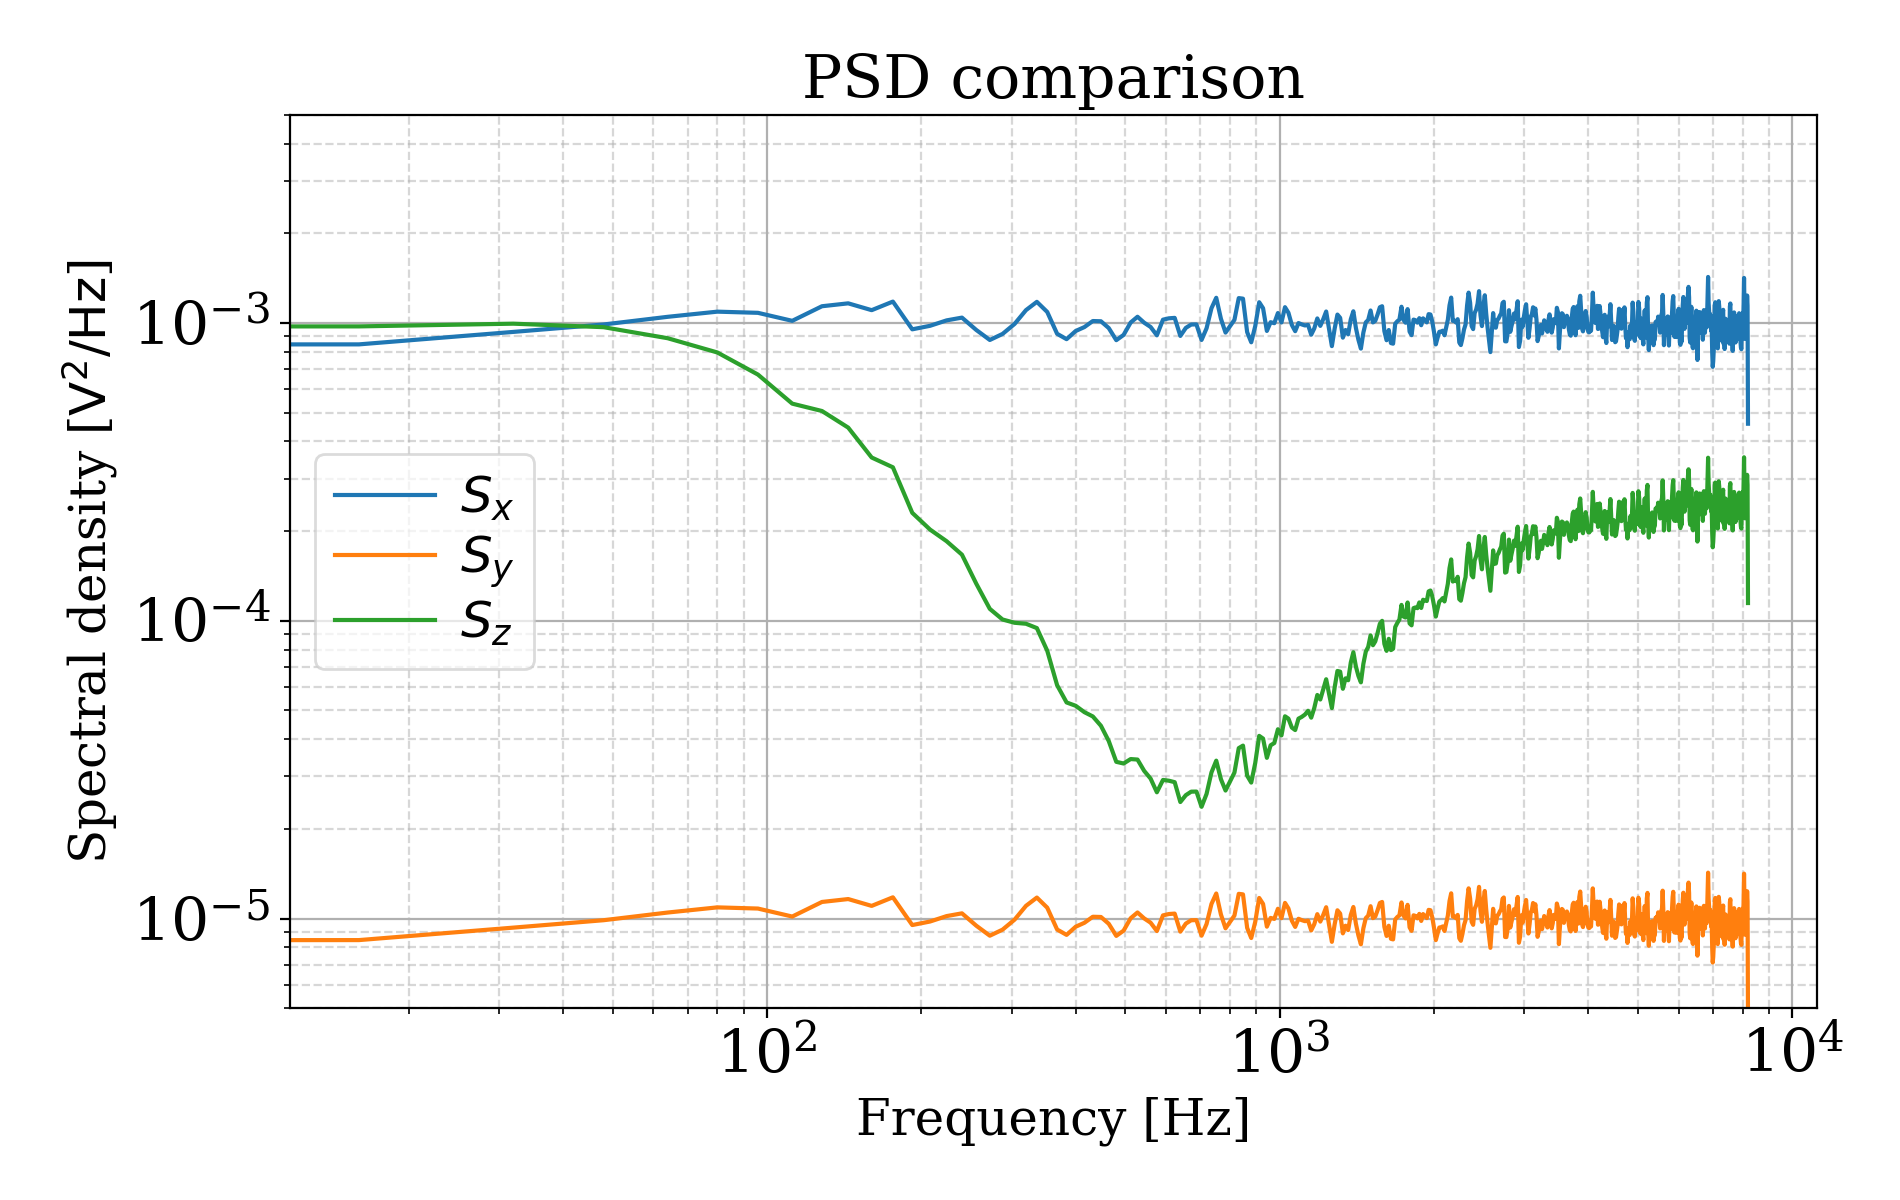

In [15]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, Sxx, label="$S_{x}$")
s1.loglog(ff, Syy, label="$S_{y}$")
s1.loglog(ff, Szz, label="$S_{z}$")


s1.set_ylim([5e-6, 5e-3])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("PSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Coherences
Should be perfectly one, because all signals originate directly from $x(t)$

<IPython.core.display.Javascript object>


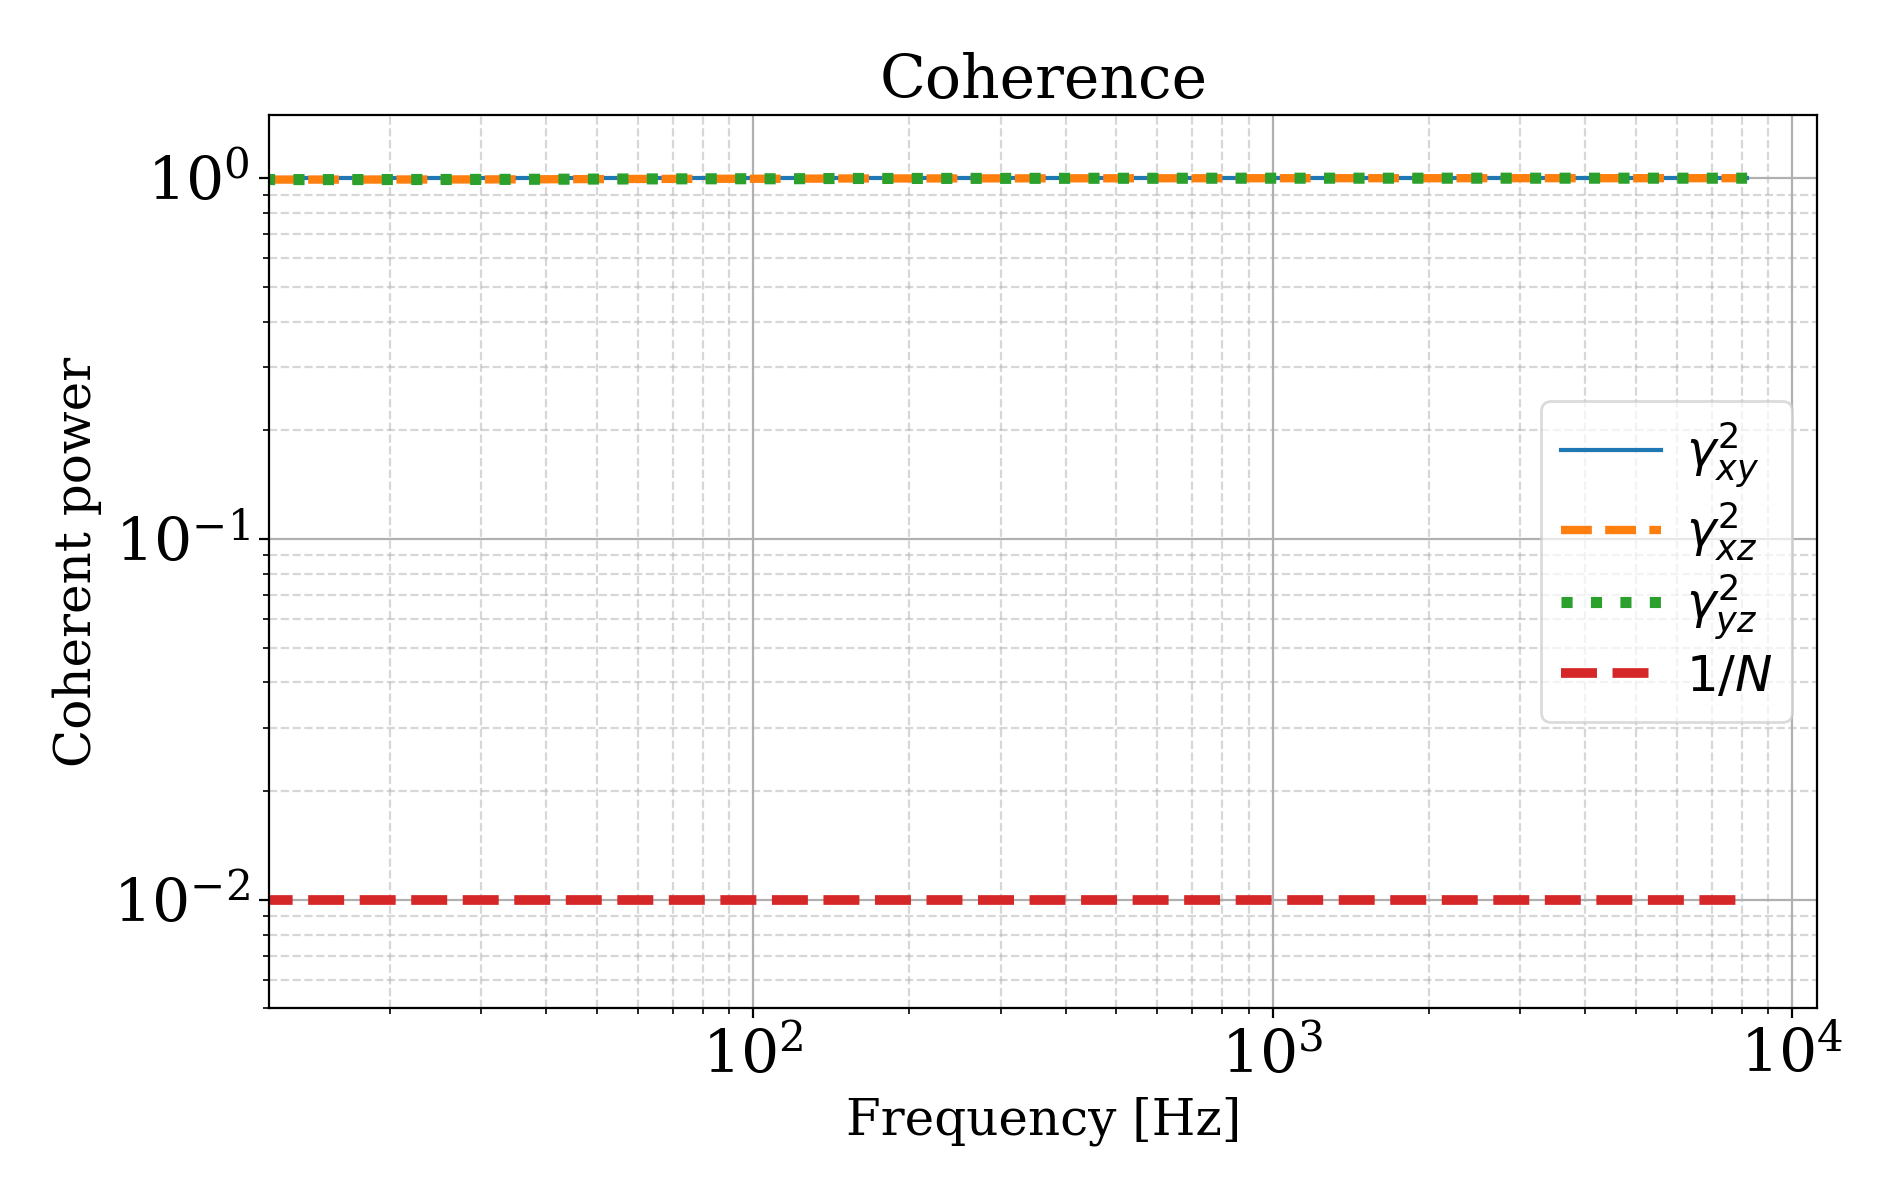

In [16]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, Cxy, label="$\gamma^2_{xy}$")
s1.loglog(ff, Cxz, ls='--', lw=3, label="$\gamma^2_{xz}$")
s1.loglog(ff, Cyz, ls=':', lw=4, label="$\gamma^2_{yz}$")

s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

s1.set_ylim([5e-3, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Coherence")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Cross spectral densities

<IPython.core.display.Javascript object>


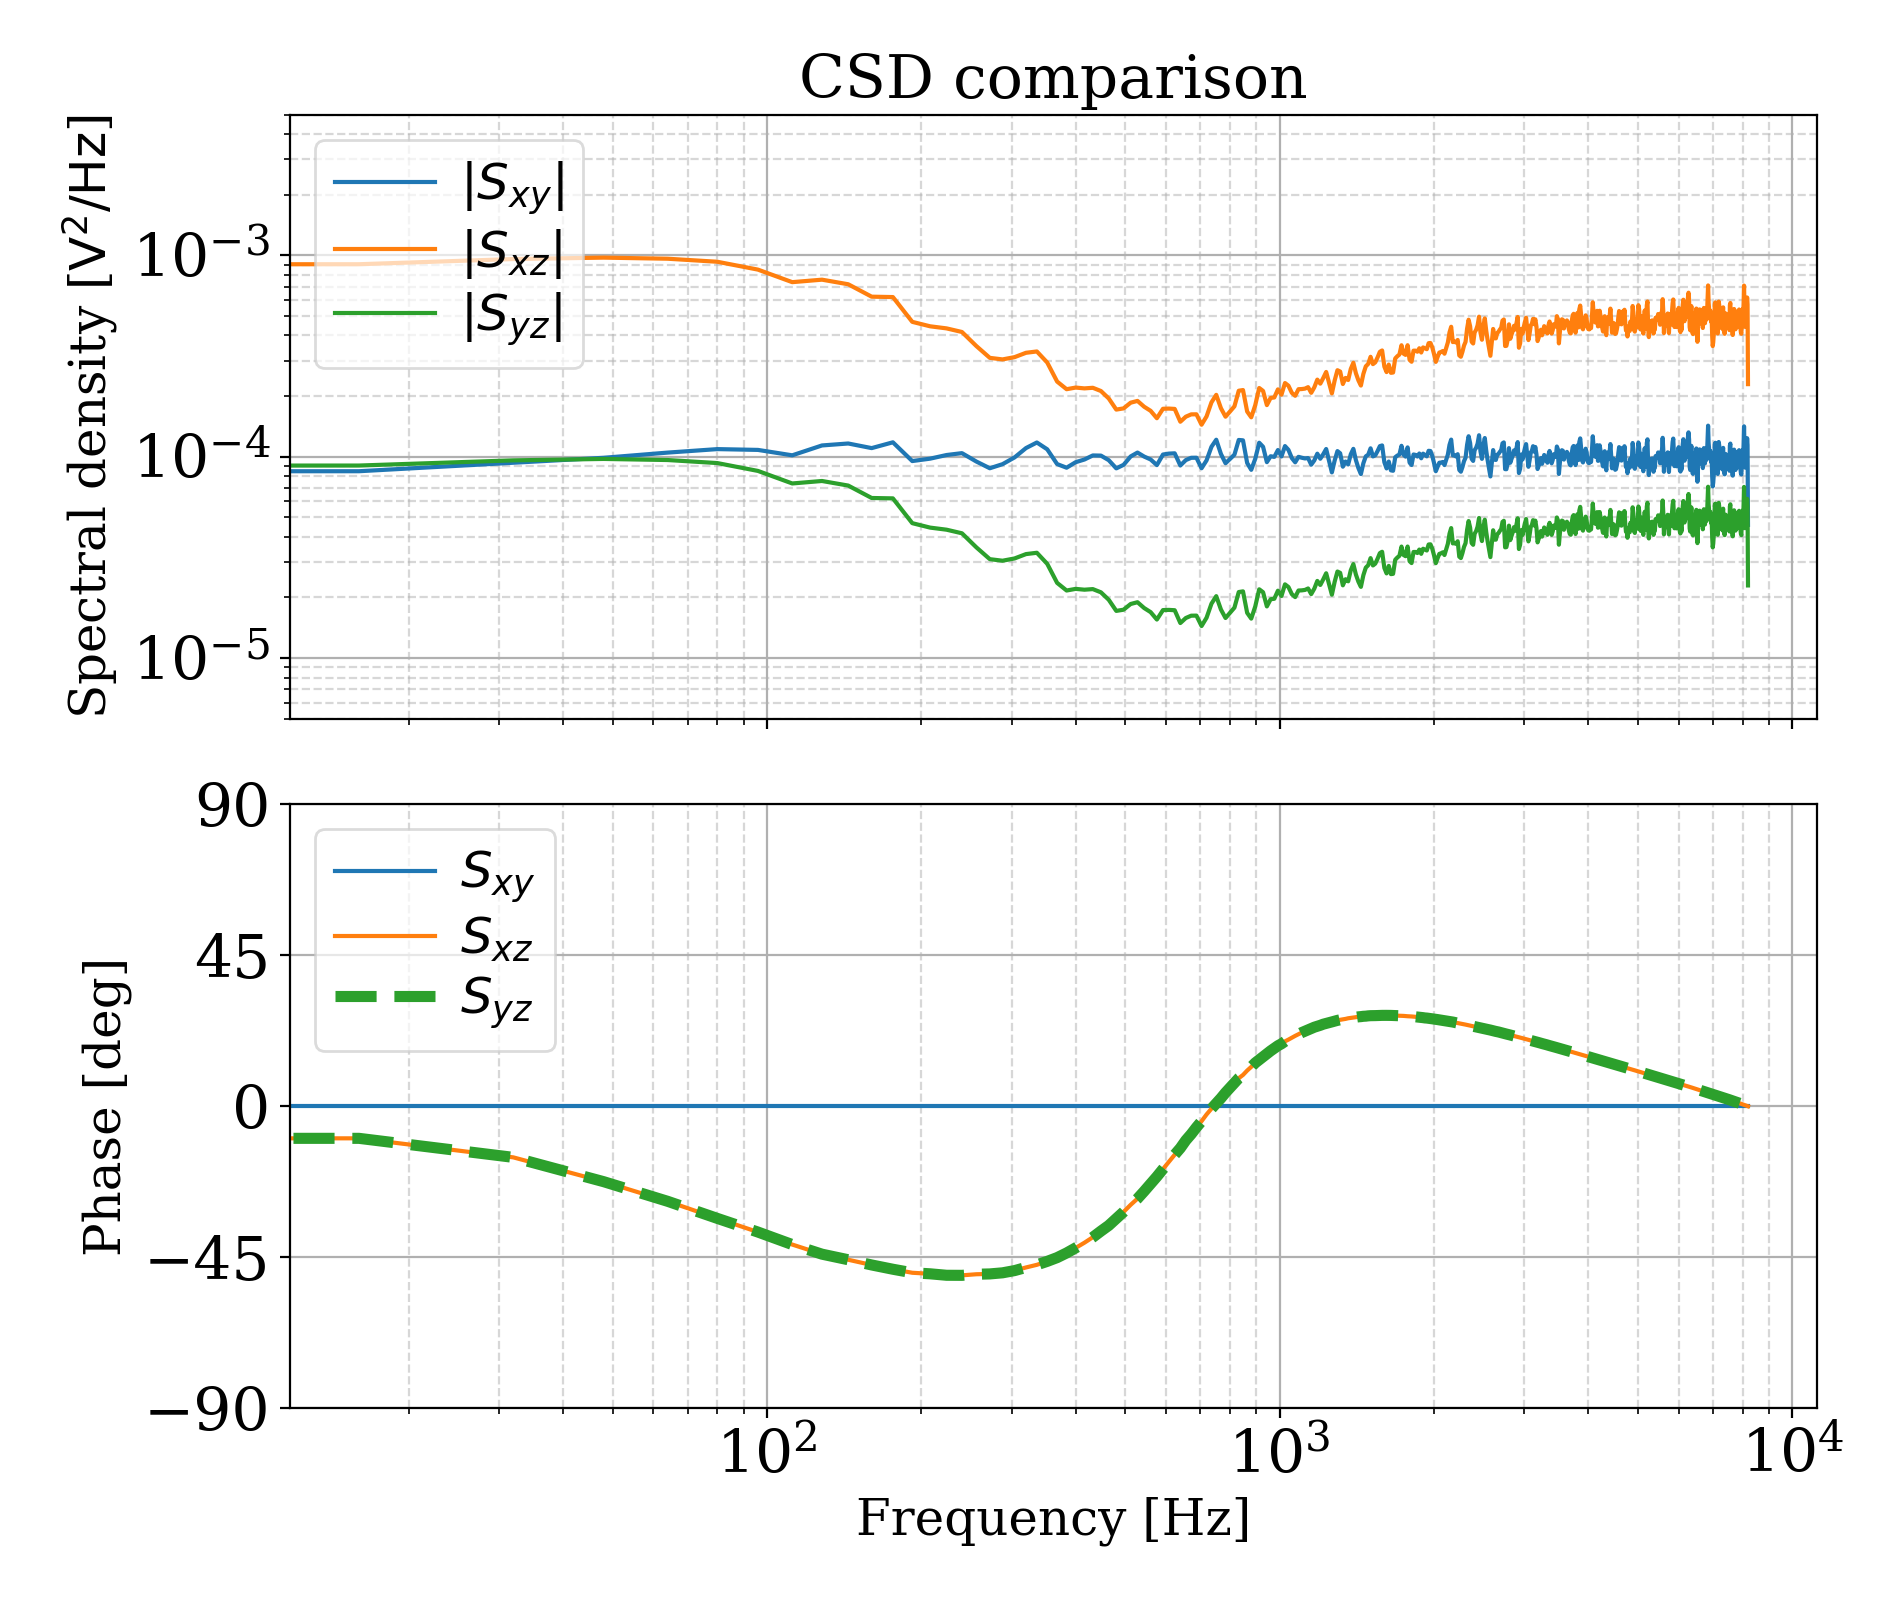

In [17]:
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(Sxy), label="$|S_{xy}|$")
s2.semilogx(ff, np.angle(Sxy, deg=True), label="$S_{xy}$")
s1.loglog(ff, np.abs(Sxz), label="$|S_{xz}|$")
s2.semilogx(ff, np.angle(Sxz, deg=True), label="$S_{xz}$")
s1.loglog(ff, np.abs(Syz), label="$|S_{yz}|$")
s2.semilogx(ff, np.angle(Syz, deg=True), ls="--", lw=4, label="$S_{yz}$")


s1.set_ylim([5e-6, 5e-3])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend()
s2.legend()

s1.set_title("CSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Transfer functions (estimates and true)
$H_1, H_2, H_3$ are the true transfer functions,  
while the estimates are $H_{xy} = S_{xy}/S_x, H_{xz} = S_{xz}/S_x, H_{yz} = S_{yz}/S_y$

<IPython.core.display.Javascript object>


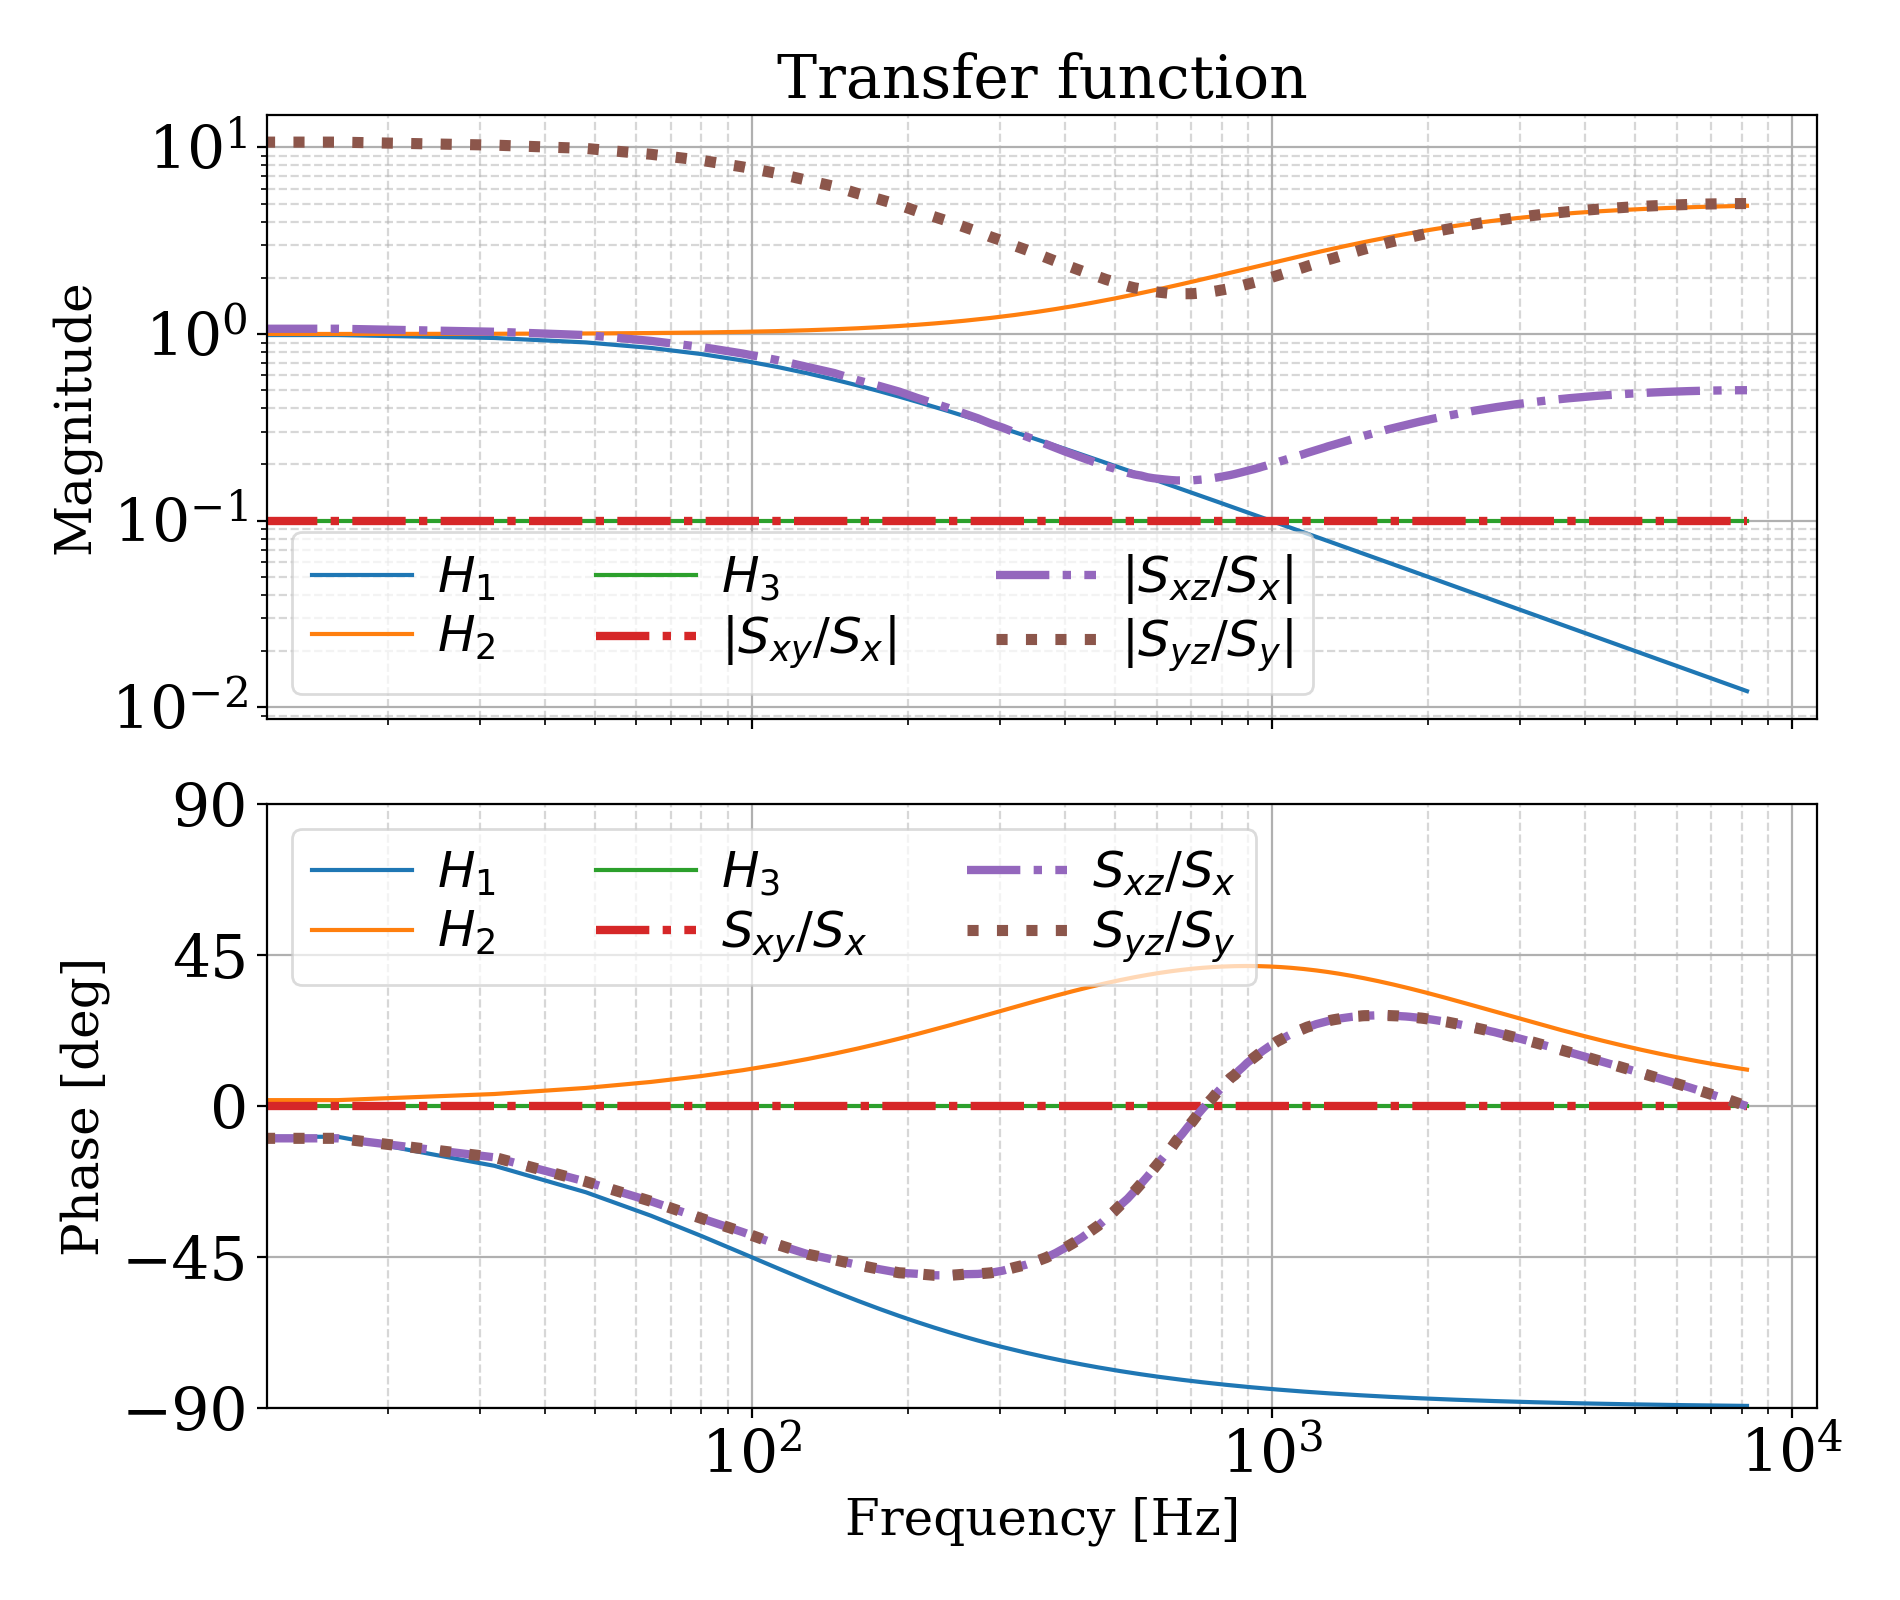

In [18]:
# Plot the transfer function
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(h1), label="$H_1$")
s2.semilogx(ff, np.angle(h1, deg=True), label="$H_1$")
s1.loglog(ff, np.abs(h2), label="$H_2$")
s2.semilogx(ff, np.angle(h2, deg=True), label="$H_2$")
s1.loglog(ff, np.abs(h3), label="$H_3$")
s2.semilogx(ff, np.angle(h3, deg=True), label="$H_3$")
# s1.loglog(ff, np.abs(hxz), label="$H_{xz} = H_1 + H_2 H_3$")
# s2.semilogx(ff, np.angle(hxz, deg=True), label="$H_{xz}$")
# s1.loglog(ff, np.abs(hyz), label="$H_{yz} = H_1 / H_3 + H_2$")
# s2.semilogx(ff, np.angle(hyz, deg=True), label="$H_{yz}$")

s1.loglog(ff, np.abs(Sxy / Sxx), ls="-.", lw=3, label="$|S_{xy}/S_x|$")
s2.semilogx(ff, np.angle(Sxy / Sxx, deg=True), ls="-.", lw=3, label="$S_{xy}/S_x$")
s1.loglog(ff, np.abs(Sxz / Sxx), ls="-.", lw=3, label="$|S_{xz}/S_x|$")
s2.semilogx(ff, np.angle(Sxz / Sxx, deg=True), ls="-.", lw=3, label="$S_{xz}/S_x$")
s1.loglog(ff, np.abs(Syz / Syy), ls=":", lw=4, label="$|S_{yz}/S_y|$")
s2.semilogx(ff, np.angle(Syz / Syy, deg=True), ls=":", lw=4, label="$S_{yz}/S_y$")

# s1.set_ylim([1e-5, 1e-2])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend(ncol=3)
s2.legend(ncol=3)

s1.set_title("Transfer function")
s1.set_ylabel("Magnitude")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Overview of Part 1
So with our current setup, we cannot differentiate between the two paths that $x(t)$ takes,  
directly through $H_1$ to $z(t)$ and via $y(t)$ through $H_2 H_3$.

# Part 2, Inject high noise $e(t)$ into $y(t)$
This will drown out the signal $x(t)$, allowing us to isolate our measurement of $H_2$ by measuring $H_{yz}$.

Importantly, $e(t)$ and $x(t)$ are *totally incoherent*, in other words, there is no way to predict what $x(t)$ is by using $e(t)$.  
This means we can differentiate the signals appearing in $z(t)$ via the two paths, because some of the signal in $z(t)$ will be known to be from $e(t)$, because we have measured $e(t)$.
Because we can isolate the signal in $z(t)$ coming from $e(t)$ via the cross spectral density $S_{xz}$

In [19]:
IFrame("./diagrams/transfer_function_signals_with_excitation.pdf", width=900, height=640)

In [20]:
### Noise power in e(t)
noise_power_density_ee = 1e-2
noise_amplitude_ee = convert_density_to_std(noise_power_density_ee, fs)

In [21]:
### Excitation signal e(t)
# base signals
new_ee = np.random.normal(scale=noise_amplitude_ee, size=nn)
new_xx = np.random.normal(scale=noise_amplitude_xx, size=nn)

# signal parts
yy2 = apply_zpk_to_time_series(new_xx, zeros_Hz_h3, poles_Hz_h3, gain_Hz_h3, fs)
new_yy = yy2 + new_ee

zz1 = apply_zpk_to_time_series(new_xx, zeros_Hz_h1, poles_Hz_h1, gain_Hz_h1, fs)
zz2 = apply_zpk_to_time_series(new_yy, zeros_Hz_h2, poles_Hz_h2, gain_Hz_h2, fs)

# total signals
new_zz = zz1 + zz2

In [22]:
### Spectral densities
# PSDs
ff, new_Sxx = sig.welch(new_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Syy = sig.welch(new_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Szz = sig.welch(new_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, new_See = sig.welch(new_ee, fs, nperseg=nperseg, noverlap=noverlap)

# CSDs
_, new_Sxy = sig.csd(new_xx, new_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Sxz = sig.csd(new_xx, new_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Syz = sig.csd(new_yy, new_zz, fs, nperseg=nperseg, noverlap=noverlap)

_, new_Sex = sig.csd(new_ee, new_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Sey = sig.csd(new_ee, new_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Sez = sig.csd(new_ee, new_zz, fs, nperseg=nperseg, noverlap=noverlap)

In [23]:
### Coherence
_, new_Cxy = sig.coherence(new_xx, new_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Cxz = sig.coherence(new_xx, new_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Cyz = sig.coherence(new_yy, new_zz, fs, nperseg=nperseg, noverlap=noverlap)

_, new_Cex = sig.coherence(new_ee, new_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Cey = sig.coherence(new_ee, new_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, new_Cez = sig.coherence(new_ee, new_zz, fs, nperseg=nperseg, noverlap=noverlap)

### Multiple coherence
By definition, the multiple coherence function $\gamma^2_{z:x,y}$ is the ratio of the ideal output spectrum due to the measured inputs $S_x, S_y$ in the absence of noise to the total measured output spectrum $S_z$, including noise.

In our case, this looks like 
$$\gamma^2_{z:x,y} = \dfrac{|H_1|^2 S_x + |H_2|^2 S_y}{S_z}$$

The above can be rearranged in terms of ordinary coherence between the output $z(t)$ and the inputs $x(t), y(t)$:
$$$$

Because we have no extraneous noise (i.e. no unknown inputs) in our system showing up in $z(t)$,  
our multiple coherence should be exactly one.

Below we'll calculate this number.

In [24]:
# Multiple coherence between z(t) and both x(t), y(t)
MC_z_xy = (np.abs(h1)**2 * new_Sxx + np.abs(h2)**2 * new_Syy) / new_Szz

### Conditioned spectra 
By definition, a *conditioned cross spectral density* $S_{ab \cdot c}$ has the influence of a signal $c(t)$ removed from the usual cross spectral density $S_{ab}$:

$$S_{ab \cdot c} = S_{ab} - \dfrac{S_{ac}}{S_c} S_{cb} $$

The second term on the right has the transfer function from $c(t)$ to $a(t)$ represented by the ratio $\dfrac{S_{ac}}{S_c}$,
the quantifies the influence that $c(t)$ exerts on $b(t)$ with $S_{cb}$.

**We are effectively subtracting away the path through $a(t)$ to $b(t)$ that $c(t)$ takes.**

We can consider the same process for a power spectral density by replacing $b \rightarrow a$ above,  
to get a *conditioned power spectral density* $S_{a \cdot c}$:

$$
\begin{align}
S_{a \cdot c} &= S_{a} - \dfrac{S_{ac}}{S_c} S_{ca} \\
&= [1 - \gamma^2_{ac}] S_{a}
\end{align}
$$



##### In our example, we want to subtract the path through $y(t)$ to $z(t)$ that $x(t)$ takes, 

so we should calculate 

$$ S_{yz \cdot x} = S_{yz} - \dfrac{S_{yx}}{S_x} S_{xz} $$

and

$$ S_{y \cdot x} = S_{y} - \dfrac{S_{yx}}{S_x} S_{xy} = [1 - \gamma^2_{xy}] S_{x}$$


In [25]:
new_Syz_x = new_Syz - (np.conj(new_Sxy) / new_Sxx) * new_Sxz

# below are equivalent
new_Syy_x_1 = new_Syy - (np.conj(new_Sxy) / new_Sxx) * new_Sxy
new_Syy_x_2 = (1 - new_Cxy) * new_Syy

### Partial coherence
By definition, the partial coherence function $\gamma^2_{ab \cdot c}$ is the coherence between two signals, e.g. the input $a(t)$ and the output $b(t)$, with the influence of a third input signal $c(t)$ removed.

$$ \gamma^2_{ab \cdot c} = \dfrac{ |S_{ab \cdot c}|^2 }{ S_{a \cdot c} S_{b} } $$

##### In our example, we want to subtract the path through $y(t)$ to $z(t)$ that $x(t)$ takes, 

so we should calculate 

$$\gamma^2_{yz \cdot x} = \dfrac{|S_{yz \cdot x}|^2}{S_{y \cdot x} S_{z}}$$

In [26]:
PCyz_x = np.abs(new_Syz_x)**2 / (new_Syy_x_2 * new_Szz)

In [27]:
# via usual CSD/PSD (potentially biased)
h2a = new_Syz / new_Syy

# via excitation CSDs (unbiased)
h2e = new_Sez / new_Sey

## Plot new power spectral densities with injection into y(t)
Notice that $e(t)$ is so strong that $S_y \approx S_e$.  
This also drastically changes $S_z$,  
but $S_x$ is the same as before.

<IPython.core.display.Javascript object>


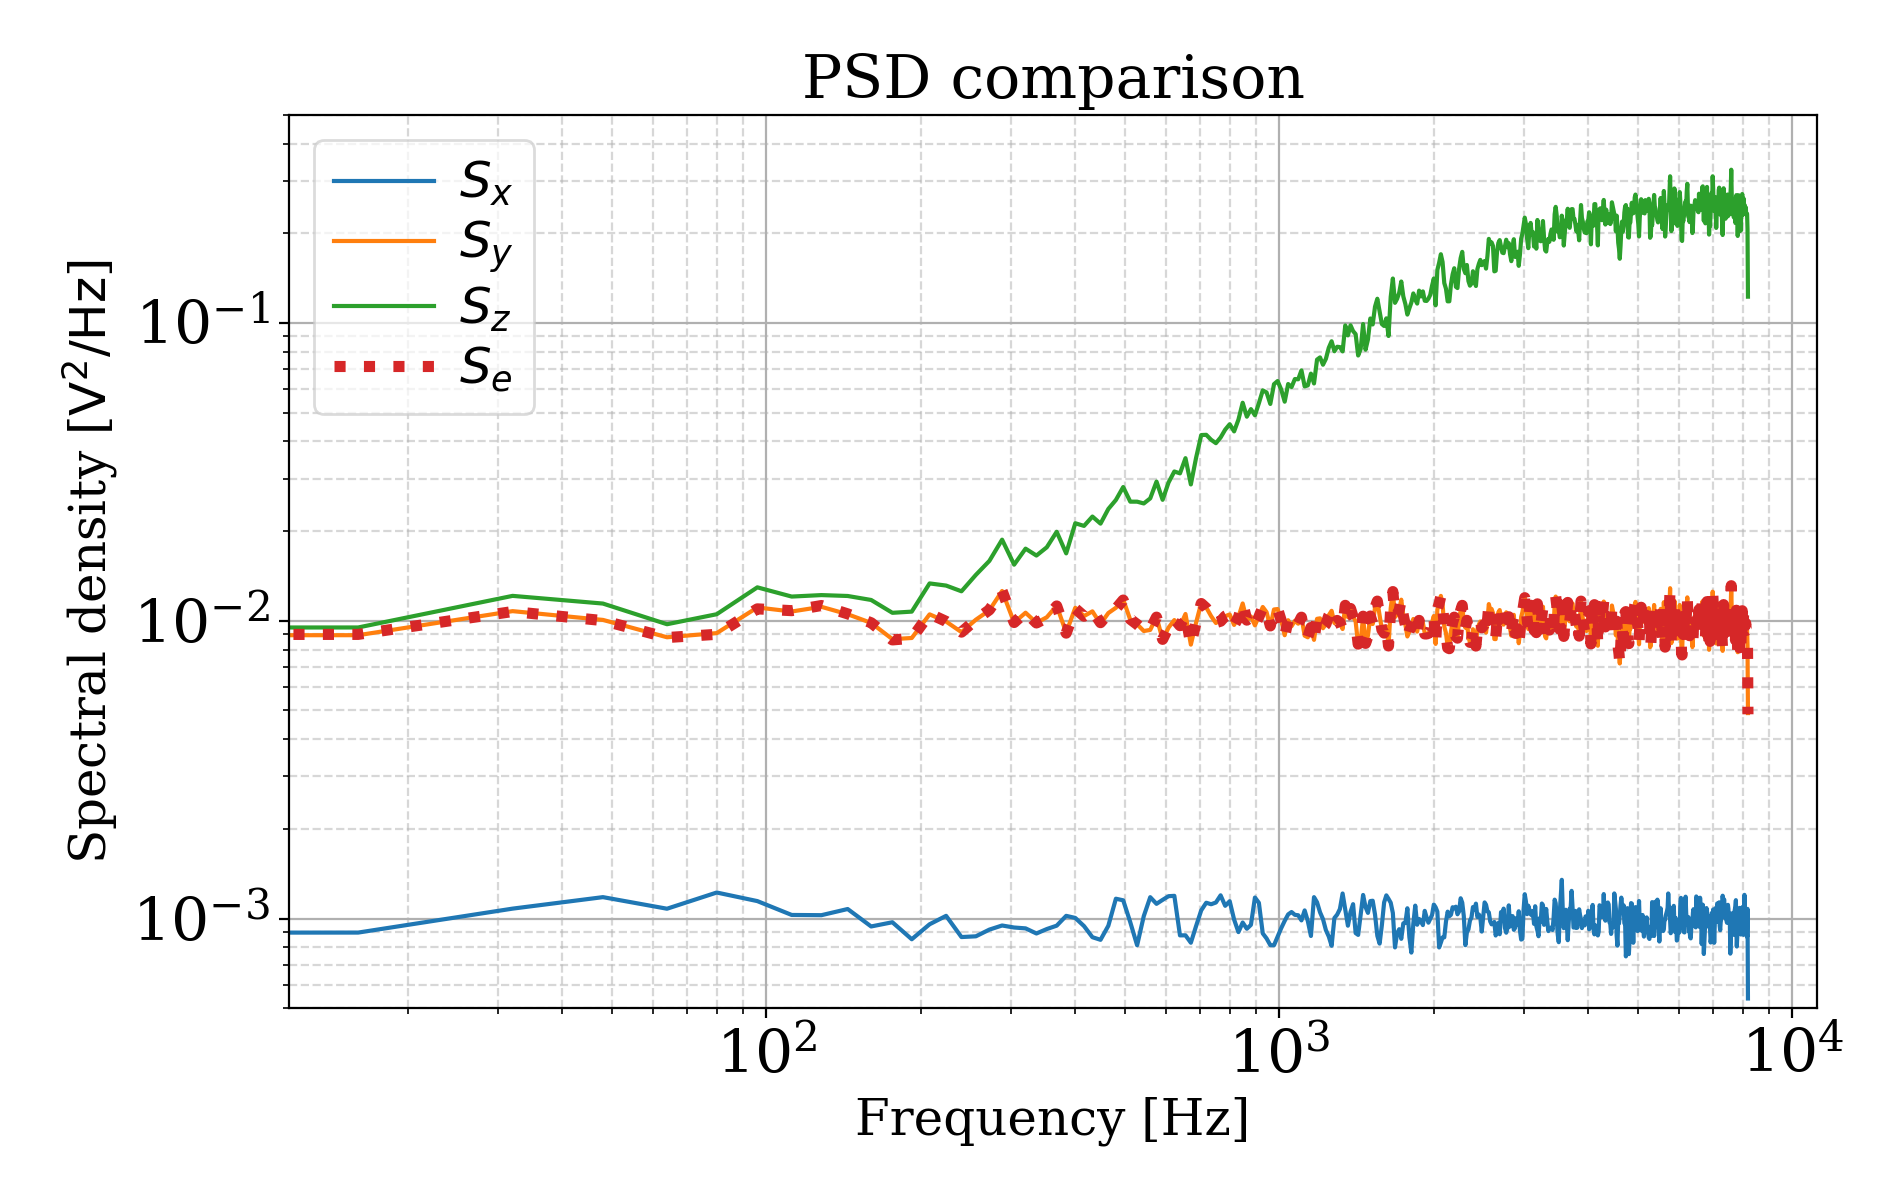

In [28]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, new_Sxx, label="$S_{x}$")
s1.loglog(ff, new_Syy, label="$S_{y}$")
s1.loglog(ff, new_Szz, label="$S_{z}$")
s1.loglog(ff, new_See, ls=':', lw=4, label="$S_{e}$")


s1.set_ylim([5e-4, 5e-1])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("PSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the conditioned spectra $S_{y \cdot x}$
This is the power spectral density $S_{y}$ with the influence of $x(t)$ removed.  Since $x(t)$ is so low, the regular and conditioned spectra should be approximately equal.

<IPython.core.display.Javascript object>


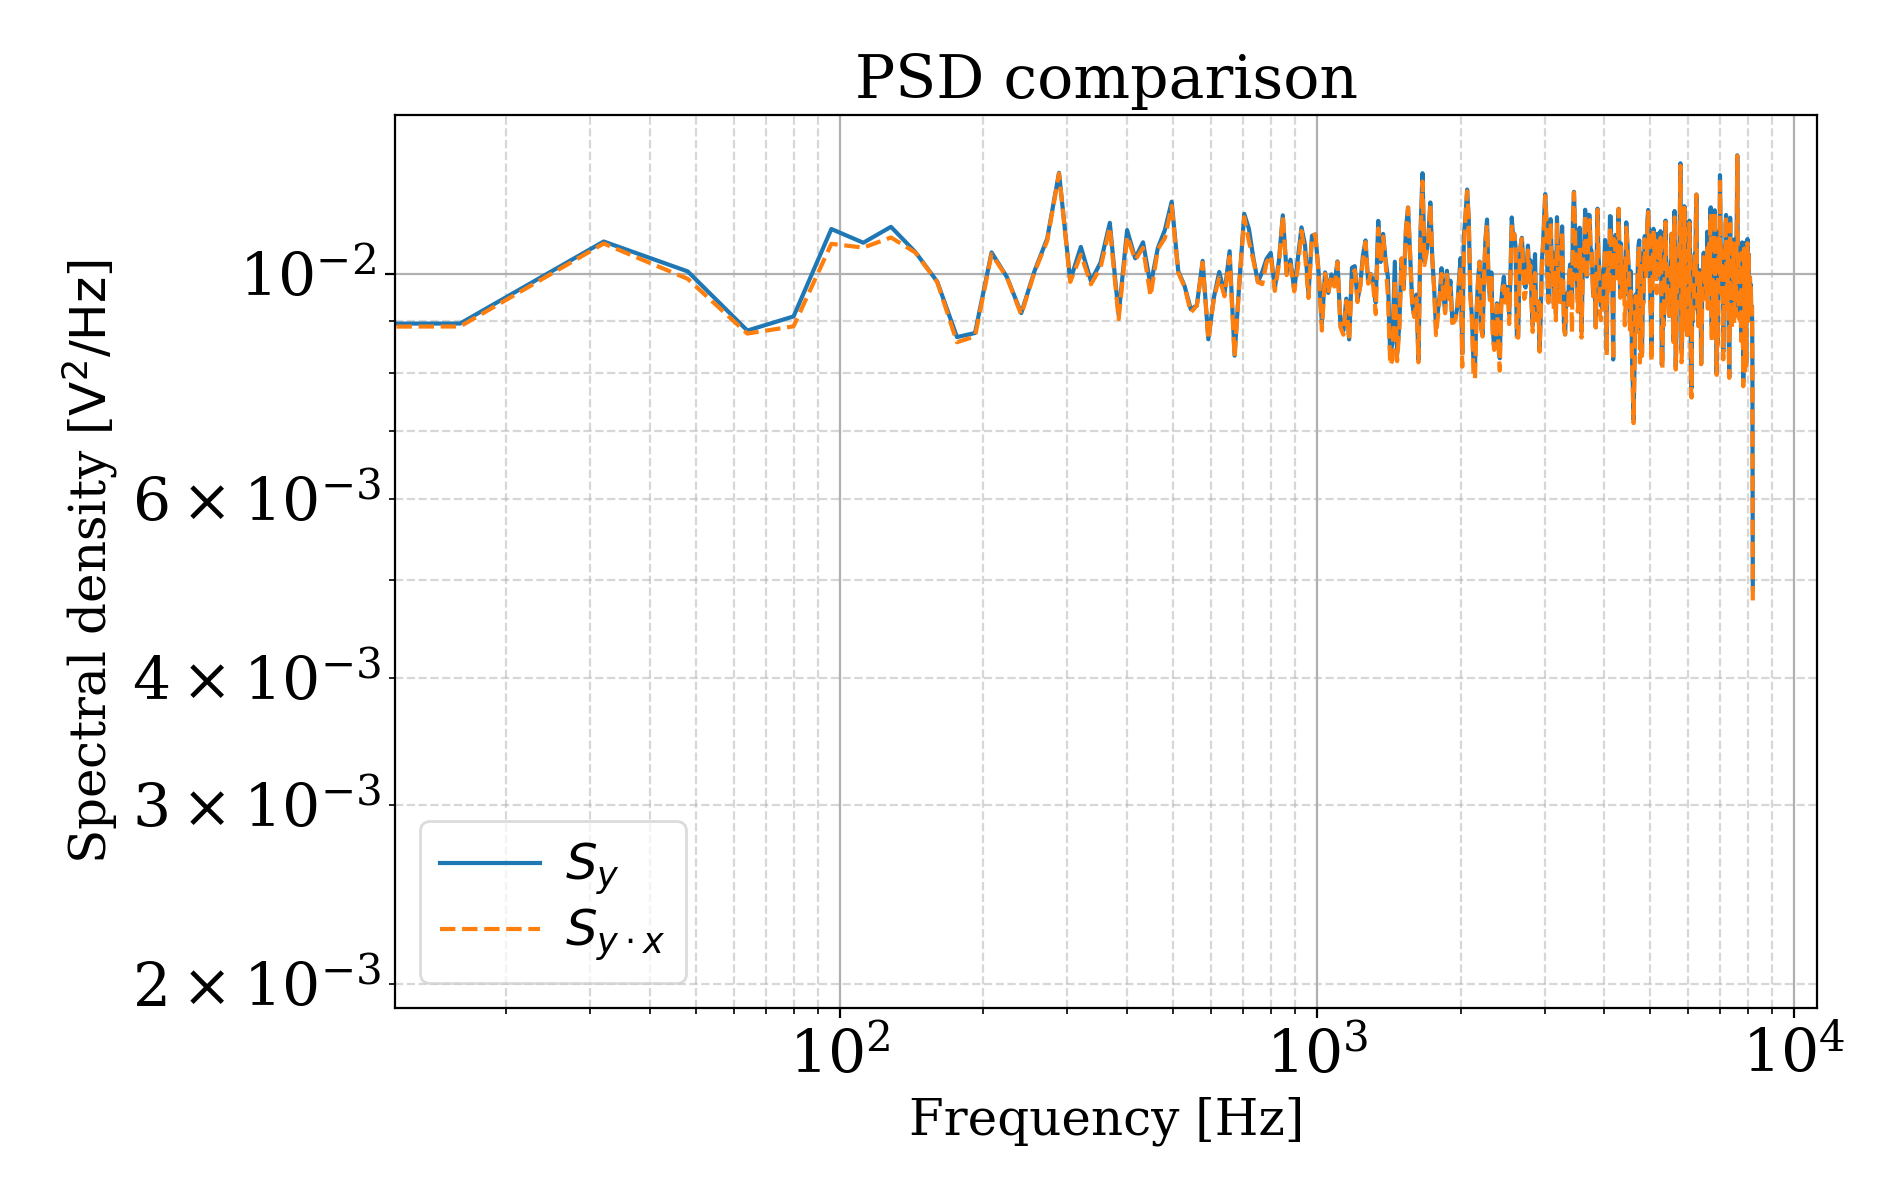

In [29]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))


s1.loglog(ff, new_Syy, label="$S_{y}$")
# s1.loglog(ff, new_Syy_x_1, ls=':', label="$S_{y \cdot x}$")
s1.loglog(ff, new_Syy_x_2, ls='--', label="$S_{y \cdot x}$")


# s1.set_ylim([5e-4, 5e-1])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("PSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the conditioned spectra $S_{yz \cdot x}$
Again, should be about equal to the regular cross spectral density $S_{yz}$

<IPython.core.display.Javascript object>


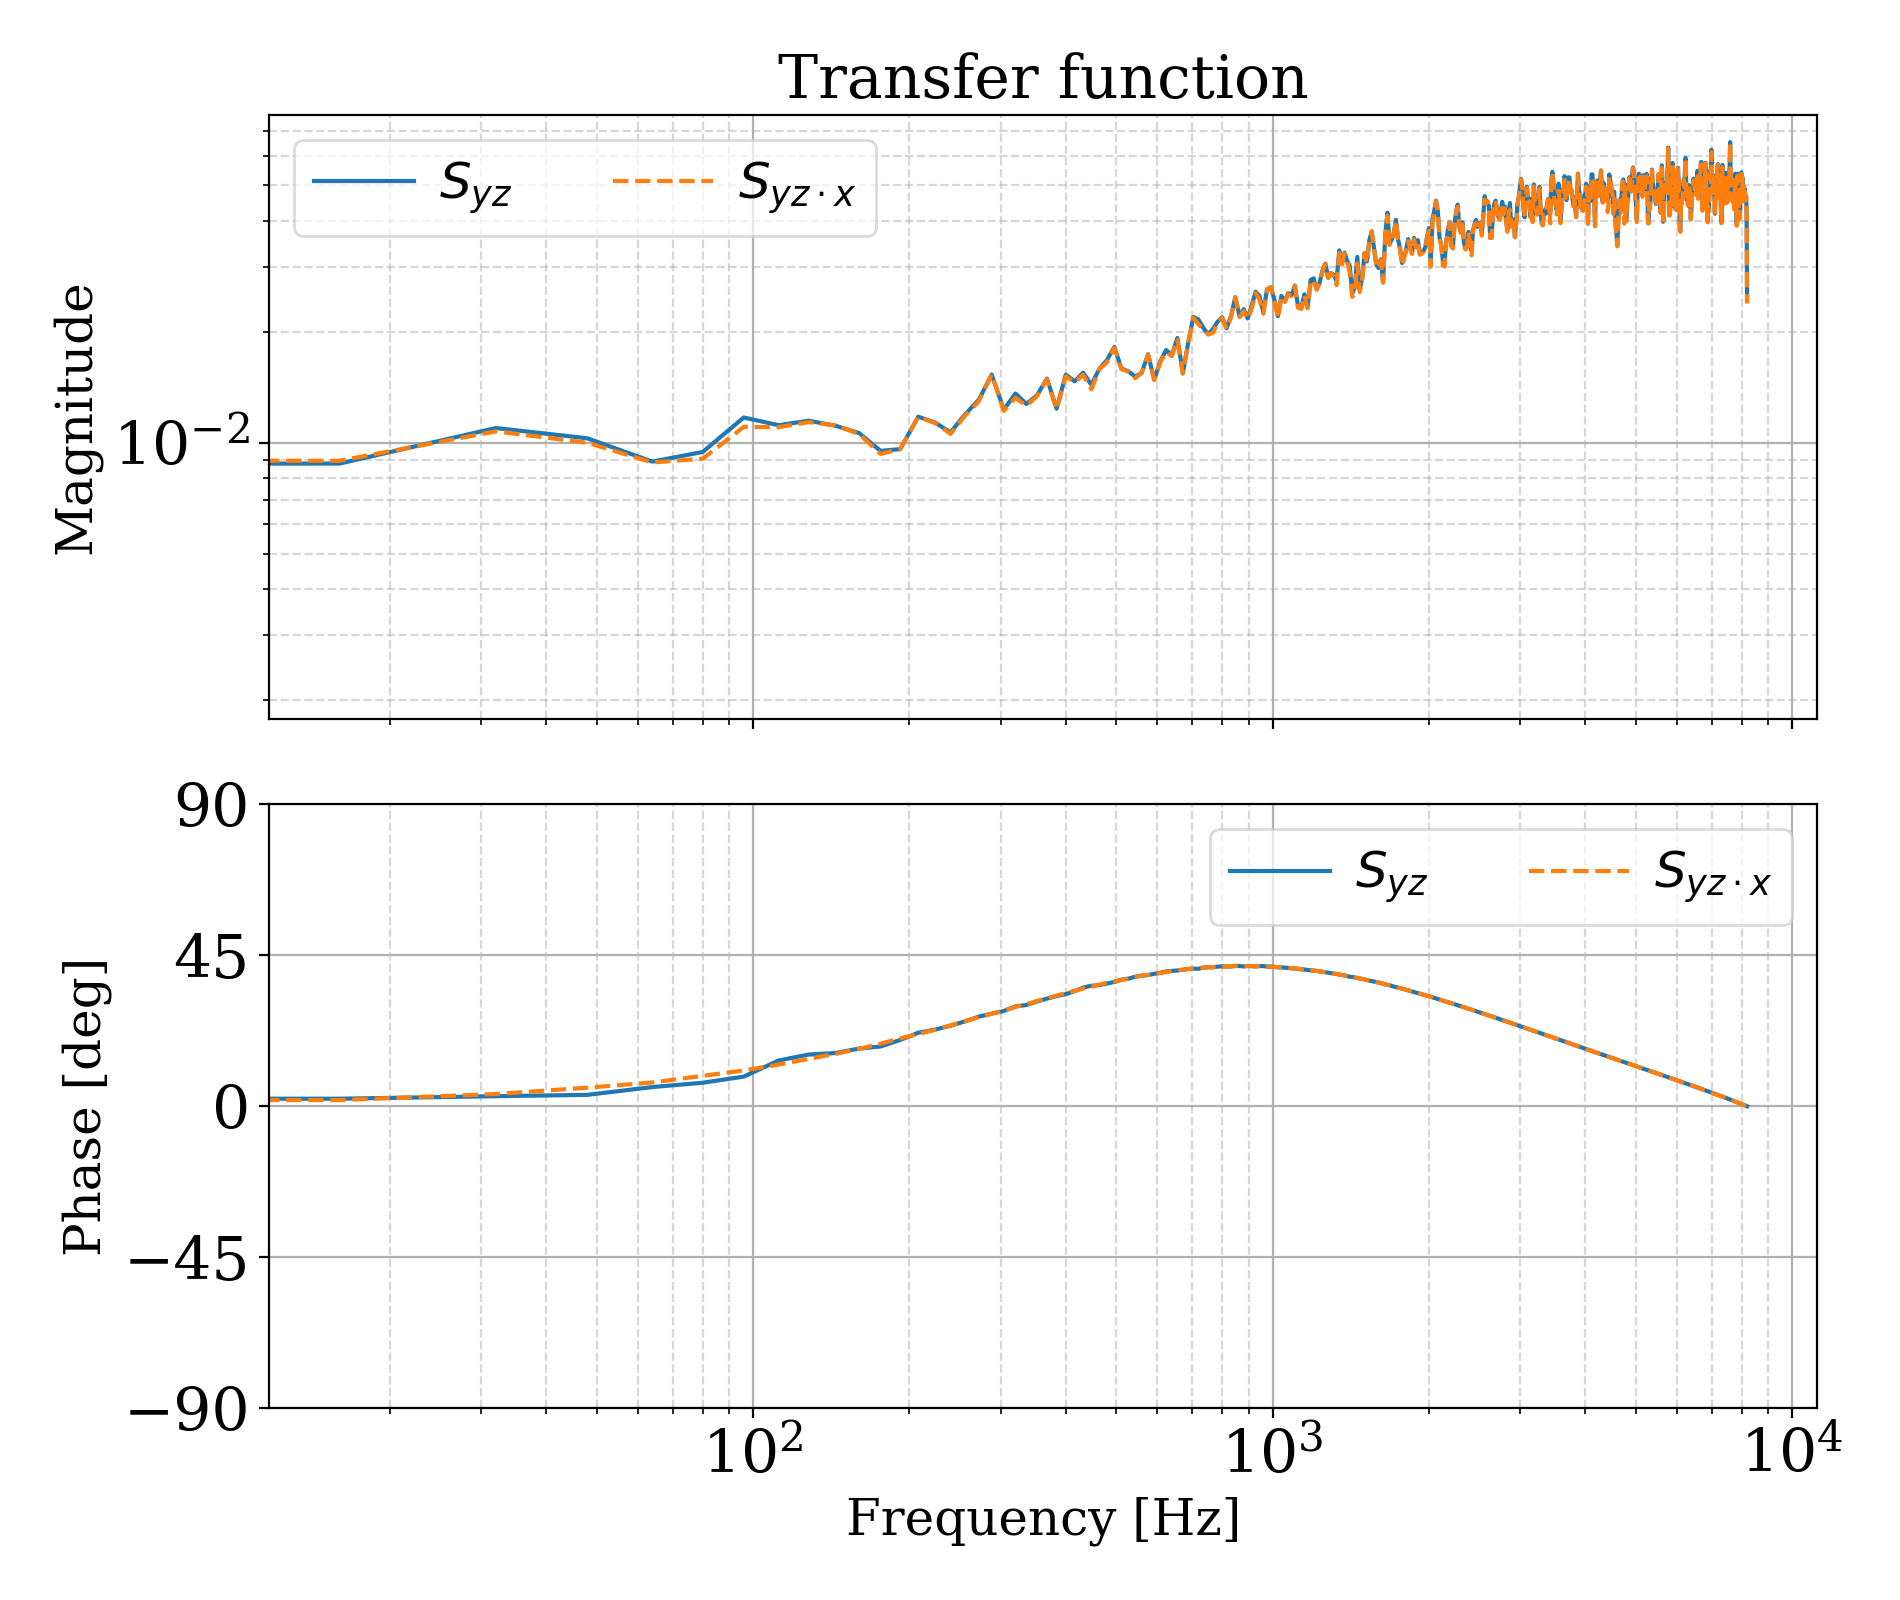

In [30]:
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(new_Syz), label="$S_{yz}$")
s2.semilogx(ff, np.angle(new_Syz, deg=True), label="$S_{yz}$")

s1.loglog(ff, np.abs(new_Syz_x), ls='--', label="$S_{yz \cdot x}$")
s2.semilogx(ff, np.angle(new_Syz_x, deg=True), ls='--', label="$S_{yz \cdot x}$")

# s1.set_ylim([5e-1, 1e1])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend(ncol=3)
s2.legend(ncol=3)

s1.set_title("Transfer function")
s1.set_ylabel("Magnitude")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the (ordinary) coherence between signals
The coherence $\gamma^2$ between any two signals can be defined as
$$\gamma^2_{ab}(f) = \dfrac{|S_{ab}(f)|^2}{S_{aa}(f) S_{bb}(f)}$$
and is thought of as a representation of how correlated two signals are in a frequency regime.

Measured coherence $\hat{\gamma}^2_{ab}$ is strongly related to the number of averages $N$.  
Two completely incoherent signals $a, b$ will return a coherence of about
$$\hat{\gamma}^2_{ab} \approx \dfrac{1}{N}$$

In this example, we should find that $x(t)$ and $e(t)$ are totally uncorrelated white noise inputs to the system.

In other words, their true coherence $\gamma^2_{ex} = 0$, because their true cross spectral density $S_{ex} = 0$.

At the same time, their measured coherence $\hat{\gamma}^2_{ex} \approx \dfrac{1}{N}$.  This is because we can never measure the true value, we can only estimate it with some level of precision determined by our random noise.  

In this case, the uncorrelated noise is the signals $x(t)$ and $e(t)$ themselves.  
When we measure a cross spectral density we look for the *correlated* noise between the two signals.  
If this correlated noise is small relative to the total noise, we will need many averages in order to resolve the correlated noise.  
This process is sometimes called "averaging away" the uncorrelated noise.

**An easy way to see if we have properly resolved our noise, 
is to check if the measured coherence $\hat{\gamma}^2_{ab} > \dfrac{1}{N}$**

<IPython.core.display.Javascript object>


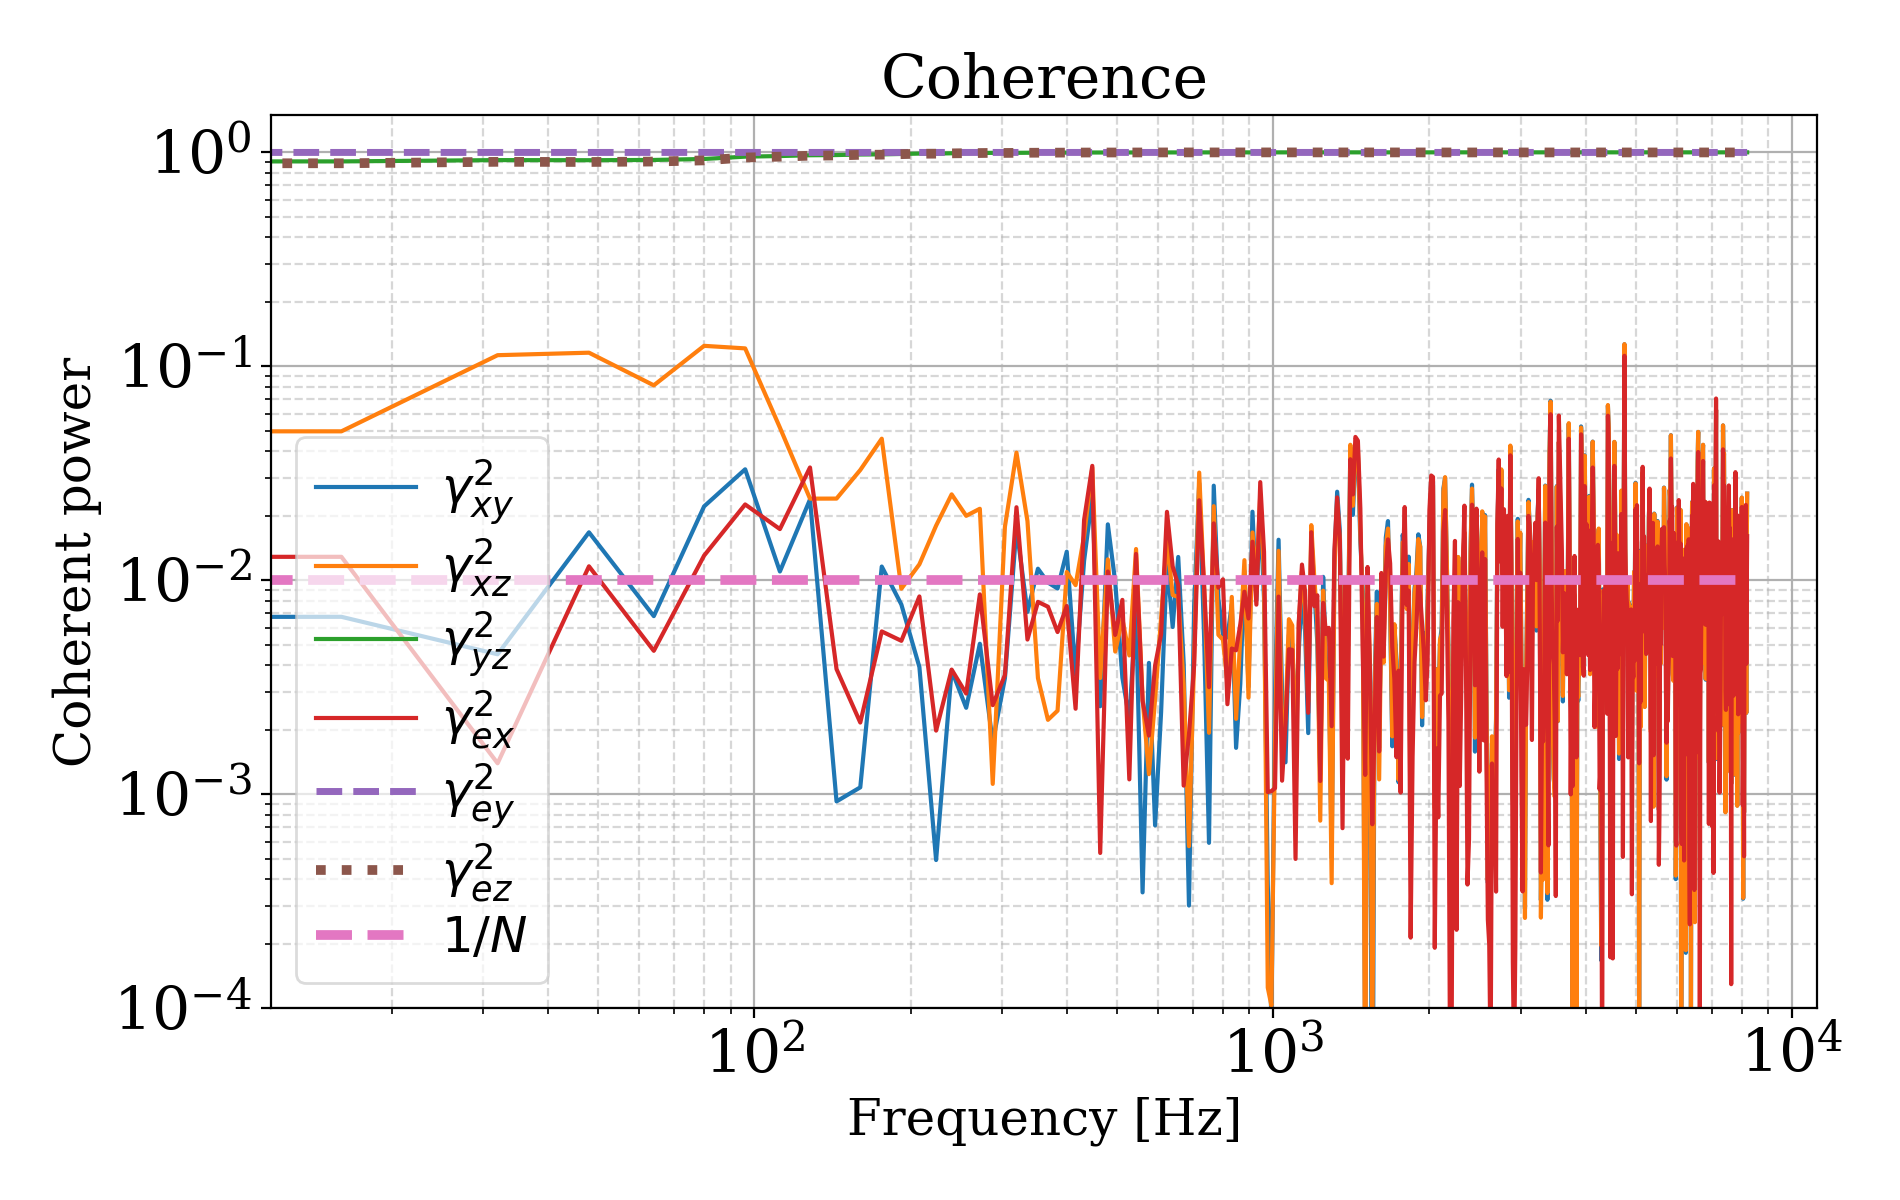

In [31]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, new_Cxy, label="$\gamma^2_{xy}$")
s1.loglog(ff, new_Cxz, label="$\gamma^2_{xz}$")
s1.loglog(ff, new_Cyz, label="$\gamma^2_{yz}$")

s1.loglog(ff, new_Cex, label="$\gamma^2_{ex}$")
s1.loglog(ff, new_Cey, lw=2.5, ls="--", label="$\gamma^2_{ey}$")
s1.loglog(ff, new_Cez, lw=3.5, ls=":", label="$\gamma^2_{ez}$")

s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

s1.set_ylim([1e-4, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Coherence")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

In the above, we see strong coherence $\hat{\gamma}^2_{yz} \approx \hat{\gamma}^2_{ey} \approx \hat{\gamma}^2_{ez} \approx 1$.  
This makes sense because $e(t)$ is very strong and overrides the appearance of $x(t)$ in both $y(t)$ and $z(t)$.

At the same time, the orange curve for $\hat{\gamma}^2_{xz} > \dfrac{1}{N}$ at low frequency ($f <$ 100 Hz}), meaning the correlated signal between $x(t)$ and $z(t)$, $\hat{S}_{xz}$, is resolved in that region.
$\hat{S}_{xz}$ is not resolved above 100 Hz, however.

## Plot multiple coherence

<IPython.core.display.Javascript object>


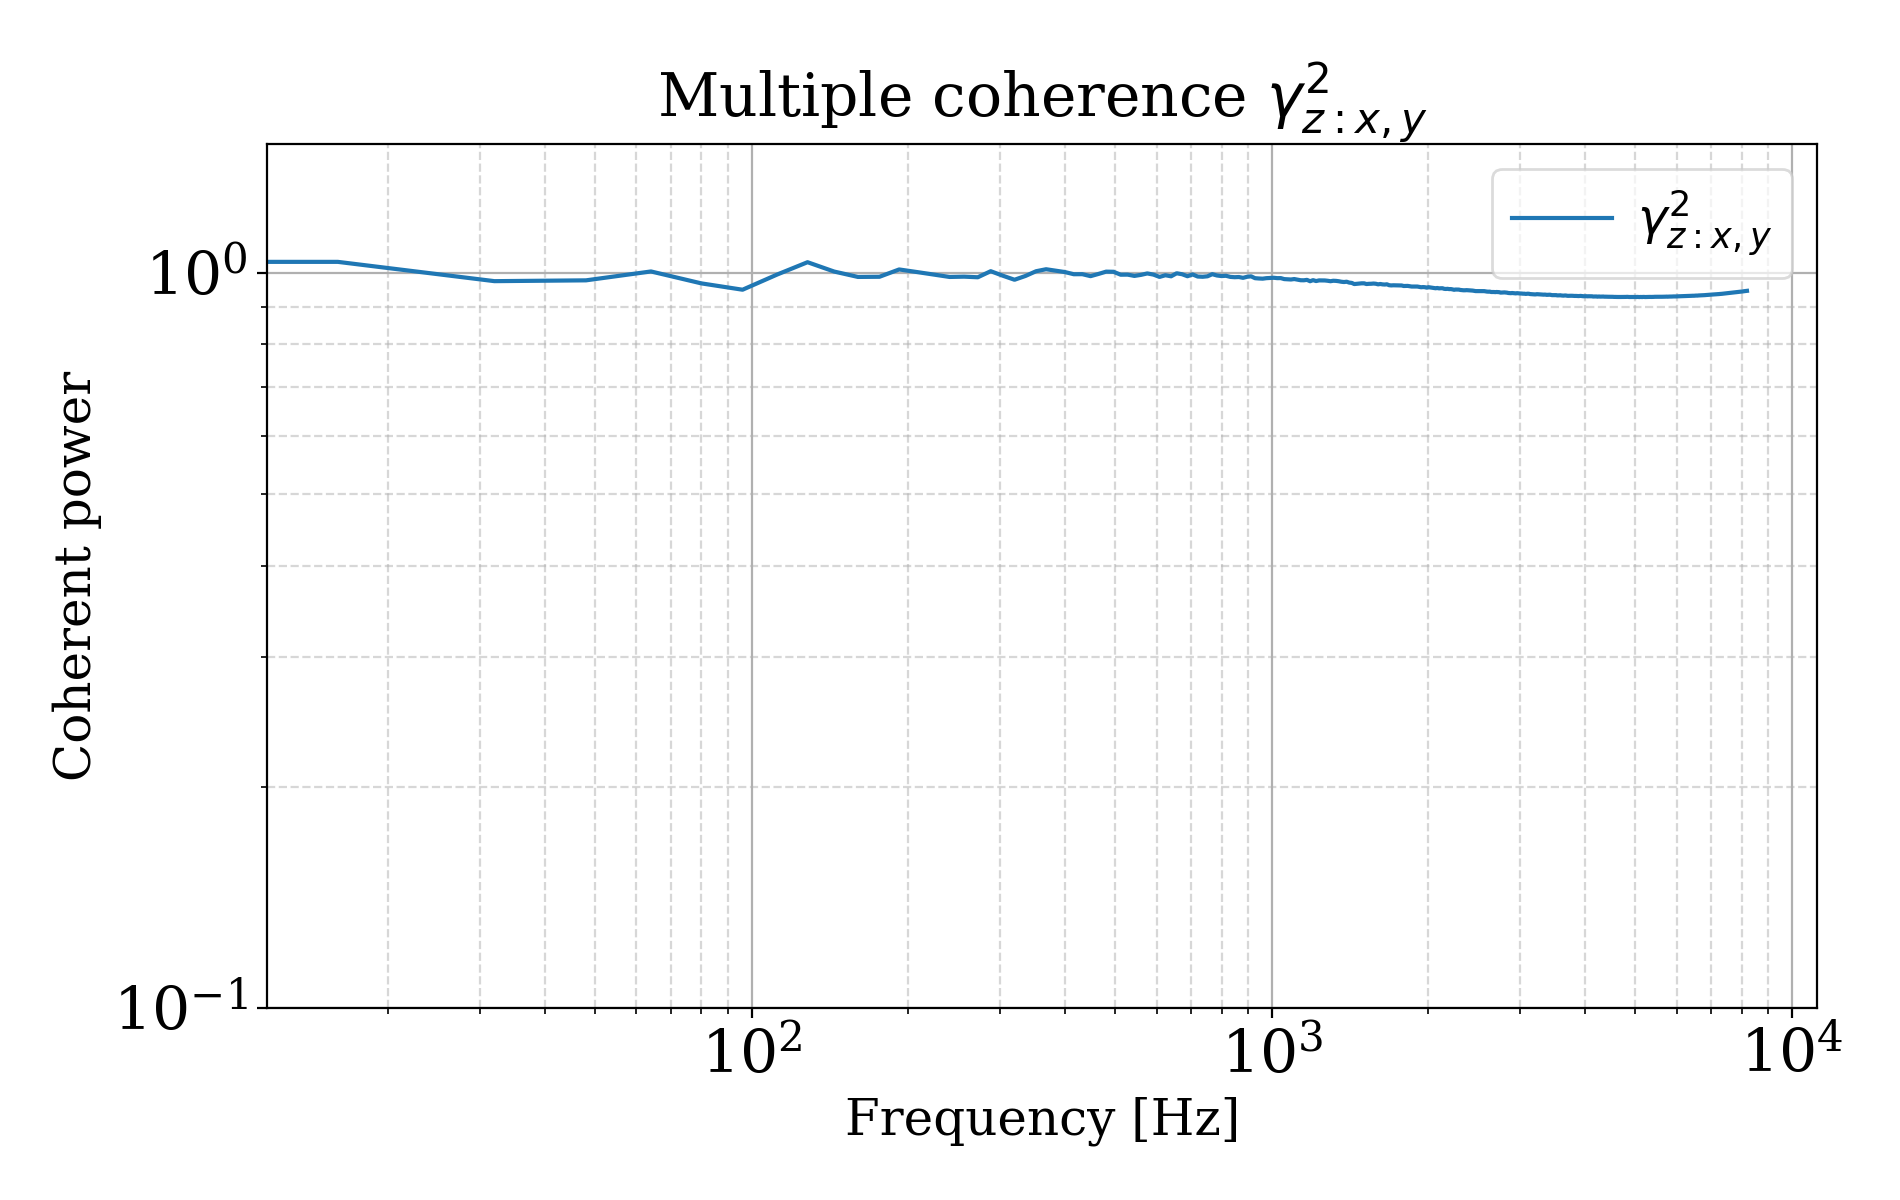

In [32]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, MC_z_xy, label="$\gamma^2_{z:x,y}$")

# s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

s1.set_ylim([1e-1, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Multiple coherence $\gamma^2_{z:x,y}$")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot partial coherence $\gamma^2_{yz \cdot x}$

<IPython.core.display.Javascript object>


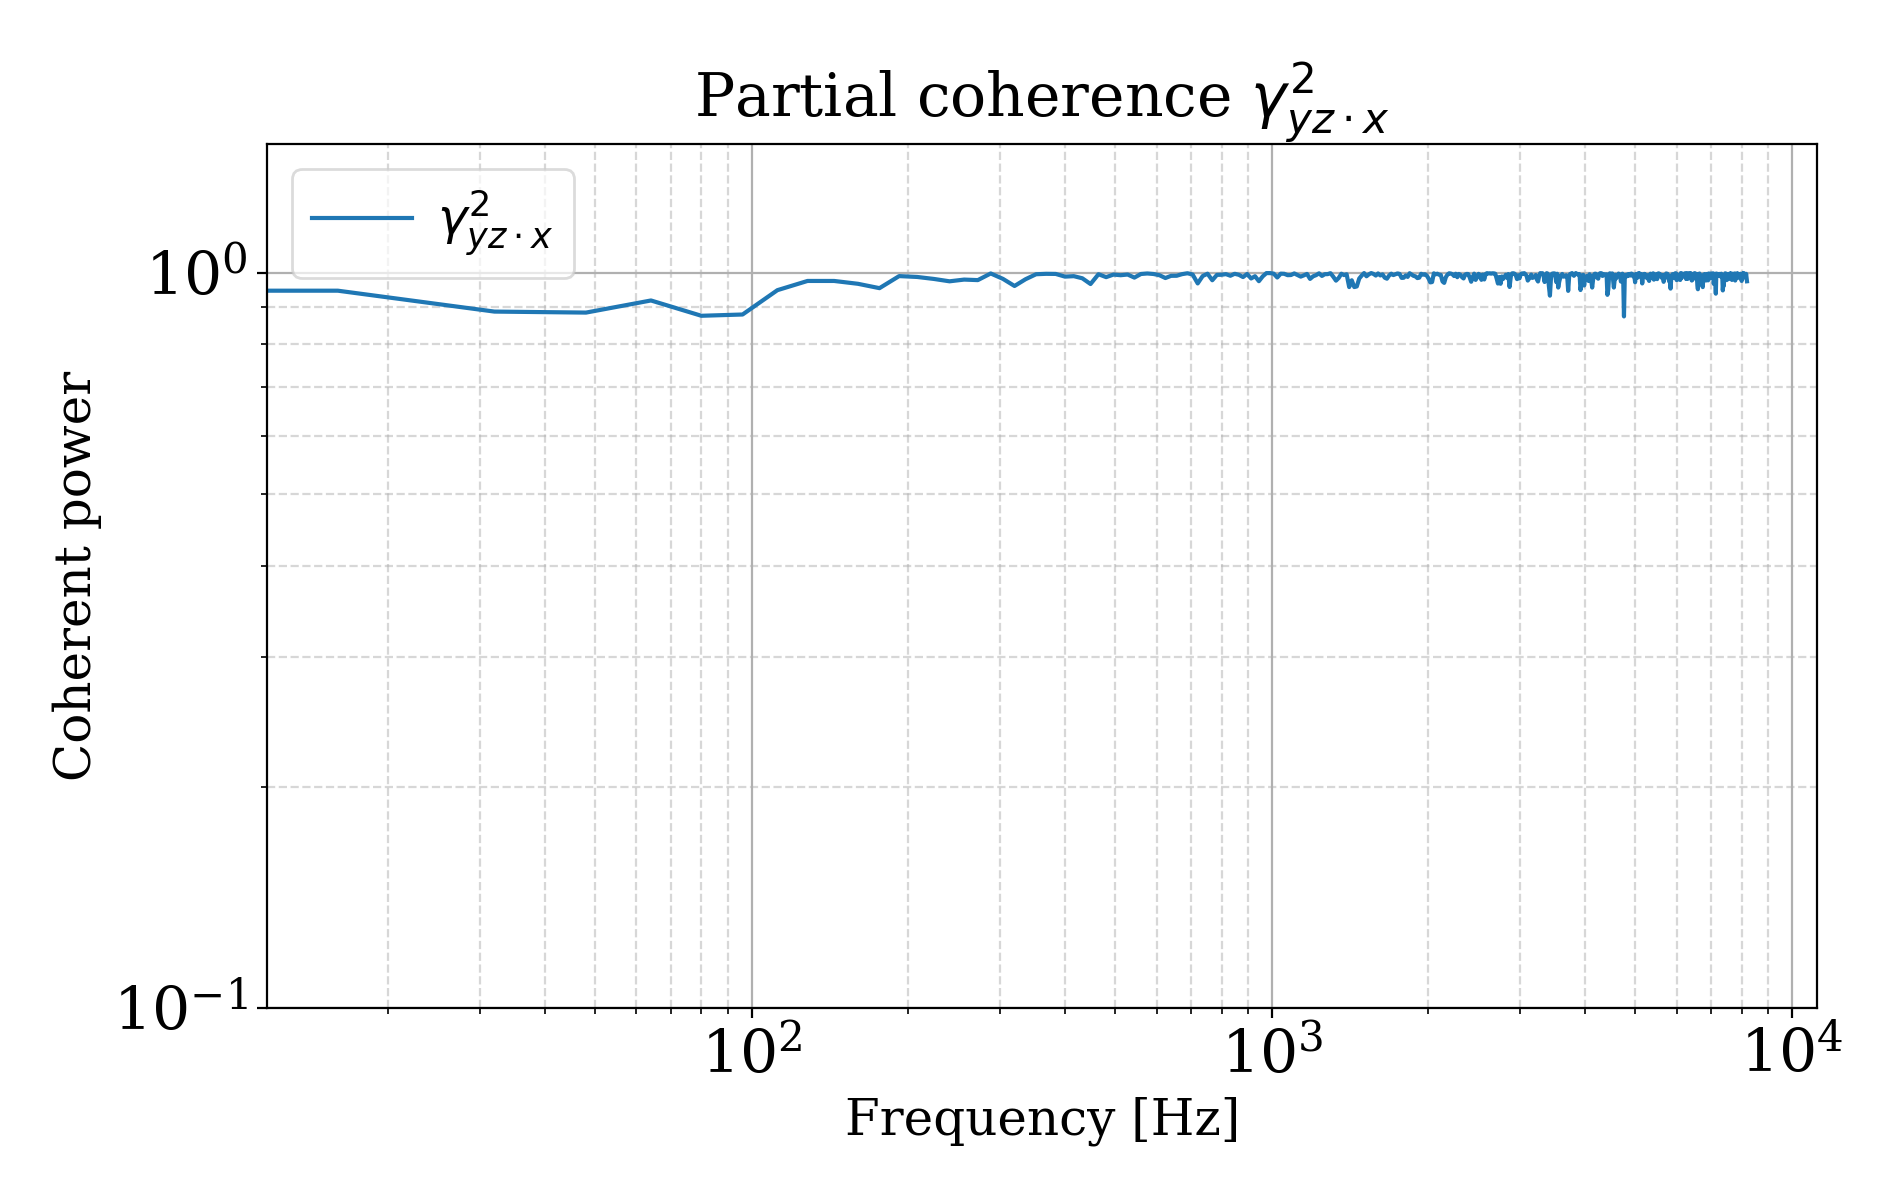

In [33]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, PCyz_x, label="$\gamma^2_{yz \cdot x}$")

# s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

s1.set_ylim([1e-1, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Partial coherence $\gamma^2_{yz \cdot x}$")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the transfer function $H_2$ and the estimates $\hat{H}_2$, $S_{yz}/S_y$ and $S_{ez}/S_{ey}$
The estimate $S_{ez}/S_{ey}$ has the advantage of being unbiased even if the excitation is not strong enough to resolve the transfer function everywhere.
We will explore this in Part 3.

<IPython.core.display.Javascript object>


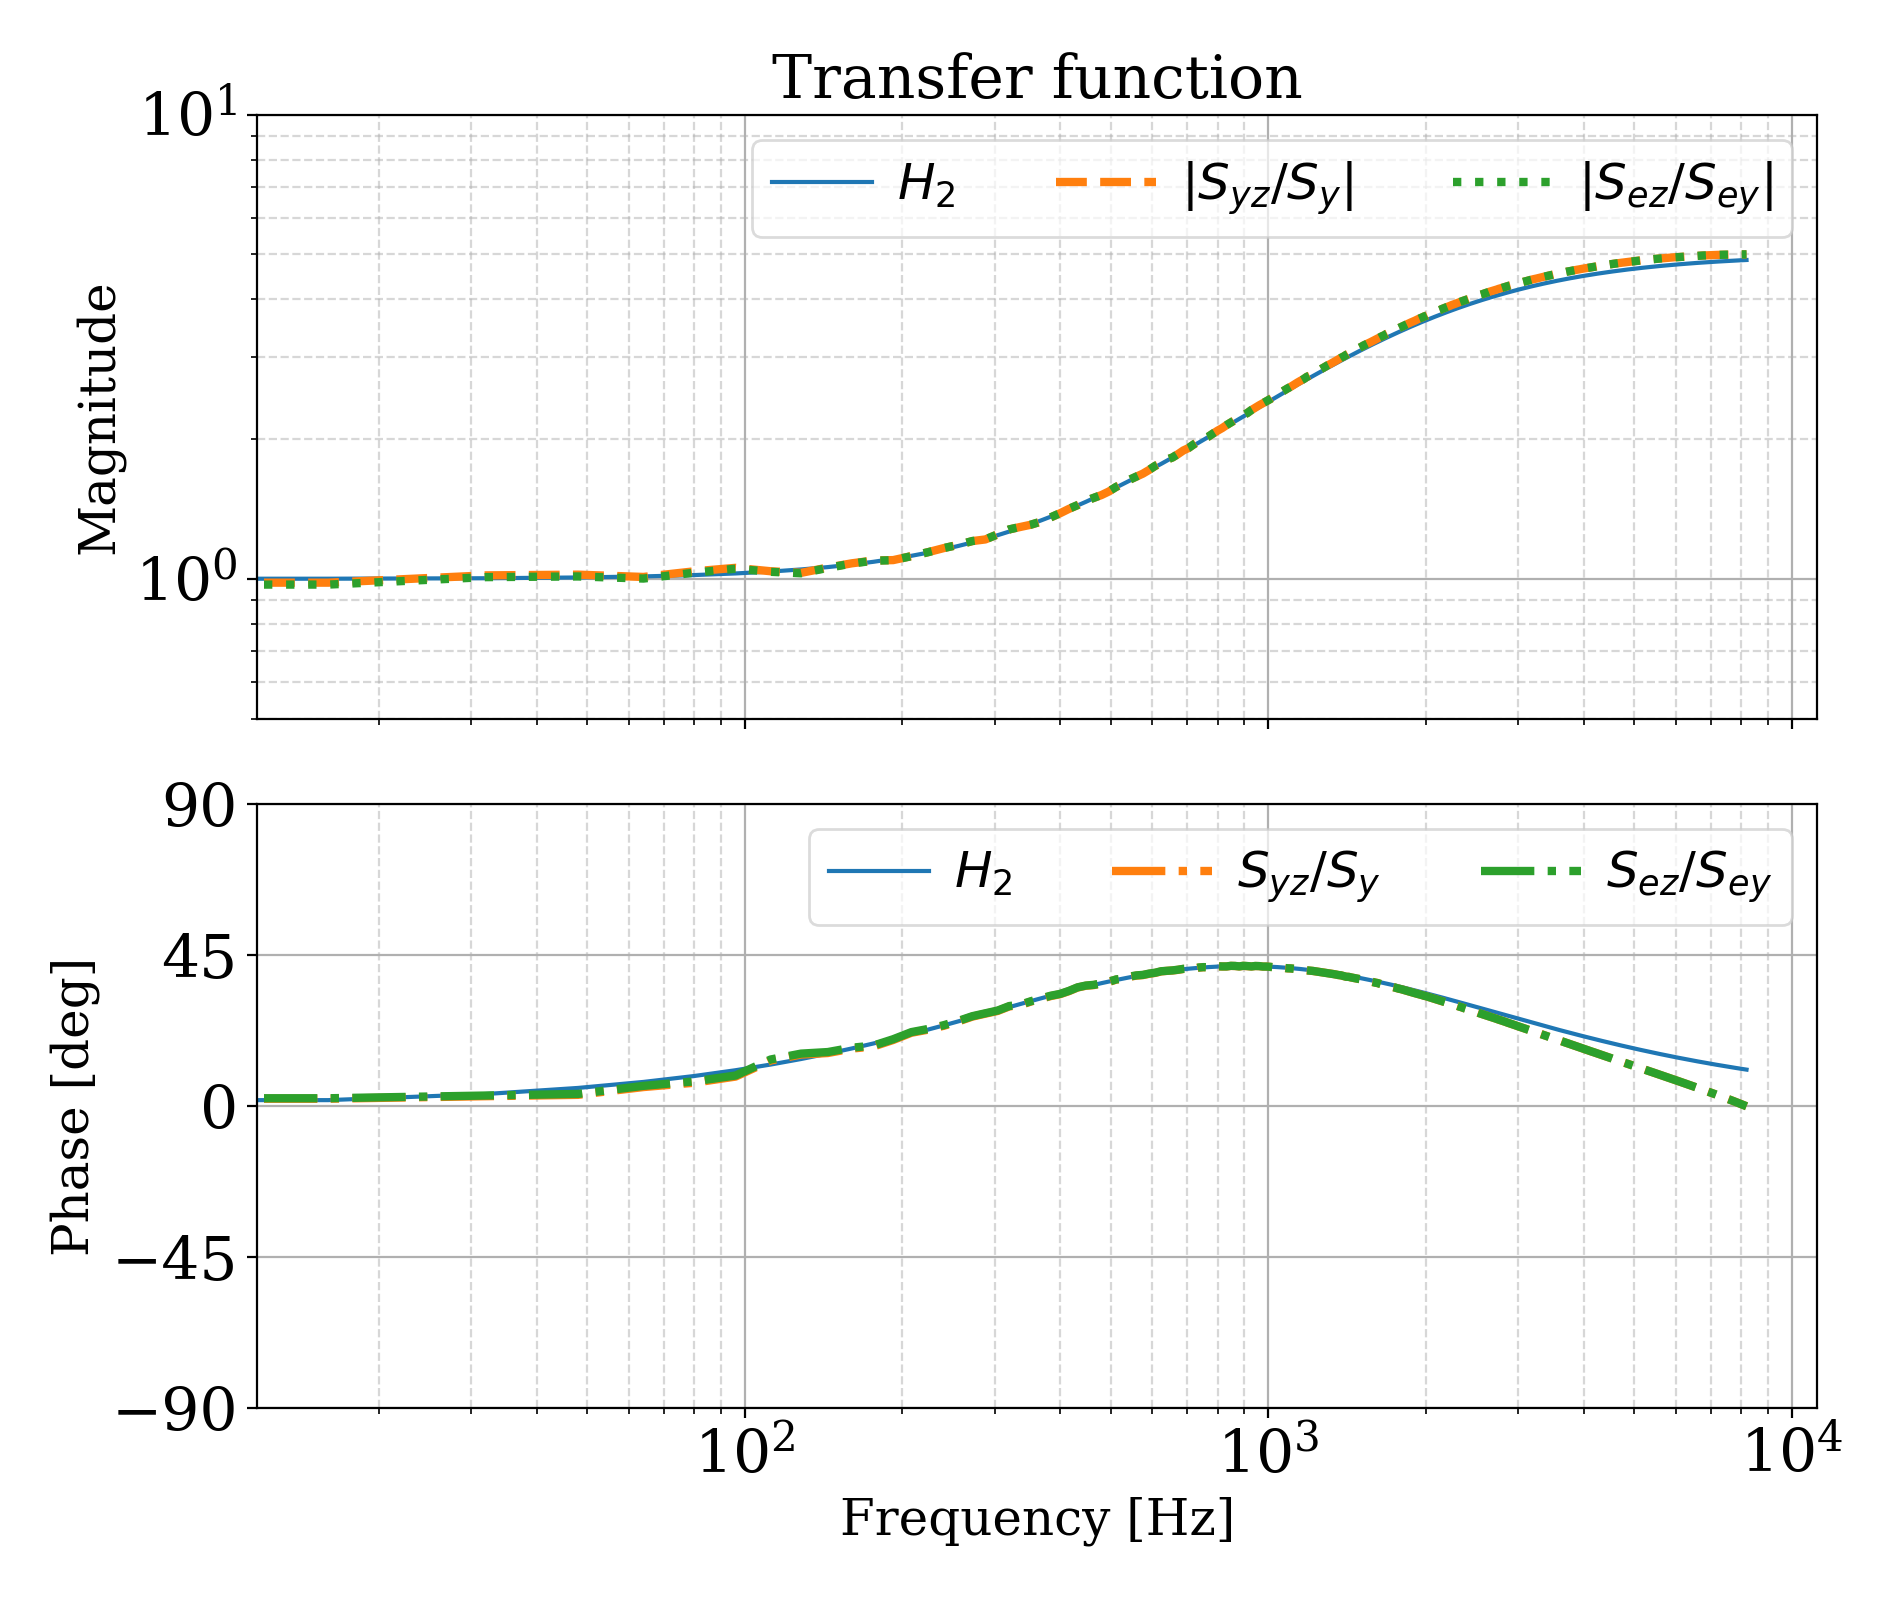

In [34]:
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(h2), label="$H_2$")
s2.semilogx(ff, np.angle(h2, deg=True), label="$H_2$")

s1.loglog(ff, np.abs(h2a), ls="--", lw=3, label="$|S_{yz}/S_y|$")
s2.semilogx(ff, np.angle(h2a, deg=True), ls="-.", lw=3, label="$S_{yz}/S_y$")
s1.loglog(ff, np.abs(h2e), ls=":", lw=3, label="$|S_{ez}/S_{ey}|$")
s2.semilogx(ff, np.angle(h2e, deg=True), ls="-.", lw=3, label="$S_{ez}/S_{ey}$")

s1.set_ylim([5e-1, 1e1])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend(ncol=3)
s2.legend(ncol=3)

s1.set_title("Transfer function")
s1.set_ylabel("Magnitude")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

# Part 3, Inject low noise $e(t)$ into $y(t)$
Sometimes, it is not possible to excite your system very hard, due to hardware limitations.
In these cases, a more subtle approach may be required.

We can still inject white noise $e(t)$ into $y(t)$, just at a much lower level, such that $e(t) \approx h_3(t) * x(t)$.  
This will partially drown out the signal $x(t)$ appearing at $z(t)$, but not fully like before in Part 2.  
We'll run through the same treatment as before, trying to measure $H_2$ by measuring $H_{yz}$.

In [35]:
### Noise power in e(t)
noise_power_density_ee = 1e-5
noise_amplitude_ee = convert_density_to_std(noise_power_density_ee, fs)

In [36]:
### Excitation signal e(t)
# base signals
p3_ee = np.random.normal(scale=noise_amplitude_ee, size=nn)
p3_xx = np.random.normal(scale=noise_amplitude_xx, size=nn)

# signal parts
yy2 = apply_zpk_to_time_series(p3_xx, zeros_Hz_h3, poles_Hz_h3, gain_Hz_h3, fs)
p3_yy = yy2 + p3_ee

zz1 = apply_zpk_to_time_series(p3_xx, zeros_Hz_h1, poles_Hz_h1, gain_Hz_h1, fs)
zz2 = apply_zpk_to_time_series(p3_yy, zeros_Hz_h2, poles_Hz_h2, gain_Hz_h2, fs)

# total signals
p3_zz = zz1 + zz2

In [37]:
### Spectral densities
# PSDs
ff, p3_Sxx = sig.welch(p3_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Syy = sig.welch(p3_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Szz = sig.welch(p3_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_See = sig.welch(p3_ee, fs, nperseg=nperseg, noverlap=noverlap)

# CSDs
_, p3_Sxy = sig.csd(p3_xx, p3_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Sxz = sig.csd(p3_xx, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Syz = sig.csd(p3_yy, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)

_, p3_Sex = sig.csd(p3_ee, p3_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Sey = sig.csd(p3_ee, p3_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Sez = sig.csd(p3_ee, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)

In [38]:
### Coherence
_, p3_Cxy = sig.coherence(p3_xx, p3_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Cxz = sig.coherence(p3_xx, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Cyz = sig.coherence(p3_yy, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)

_, p3_Cex = sig.coherence(p3_ee, p3_xx, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Cey = sig.coherence(p3_ee, p3_yy, fs, nperseg=nperseg, noverlap=noverlap)
_, p3_Cez = sig.coherence(p3_ee, p3_zz, fs, nperseg=nperseg, noverlap=noverlap)

In [39]:
### Multiple coherence
MC_z_xy = (np.abs(h1)**2 * p3_Sxx + np.abs(h2)**2 * p3_Syy) / p3_Szz

In [40]:
### Conditioned spectra (remove x(t) from y(t))
p3_Syz_x = p3_Syz - (np.conj(p3_Sxy) / p3_Sxx) * p3_Sxz
p3_Syy_x = (1 - p3_Cxy) * p3_Syy

In [41]:
### Partial coherence (remove x(t) from y(t))
p3_PCyz_x = np.abs(p3_Syz_x)**2 / (p3_Syy_x * p3_Szz)

### Measured $H_2$ transfer function in a couple ways

In [42]:
# via usual CSD/PSD (potentially biased)
p3_h2a = p3_Syz / p3_Syy

# via excitation CSDs (unbiased)
p3_h2e = p3_Sez / p3_Sey

# via conditioned CSD/PSD with x(t) removed
p3_h2c = p3_Syz_x / p3_Syy_x

## Plot new power spectral densities with injection into y(t)
Notice that $e(t)$ is so strong that $S_y \approx S_e$.  
This also drastically changes $S_z$,  
but $S_x$ is the same as before.

<IPython.core.display.Javascript object>


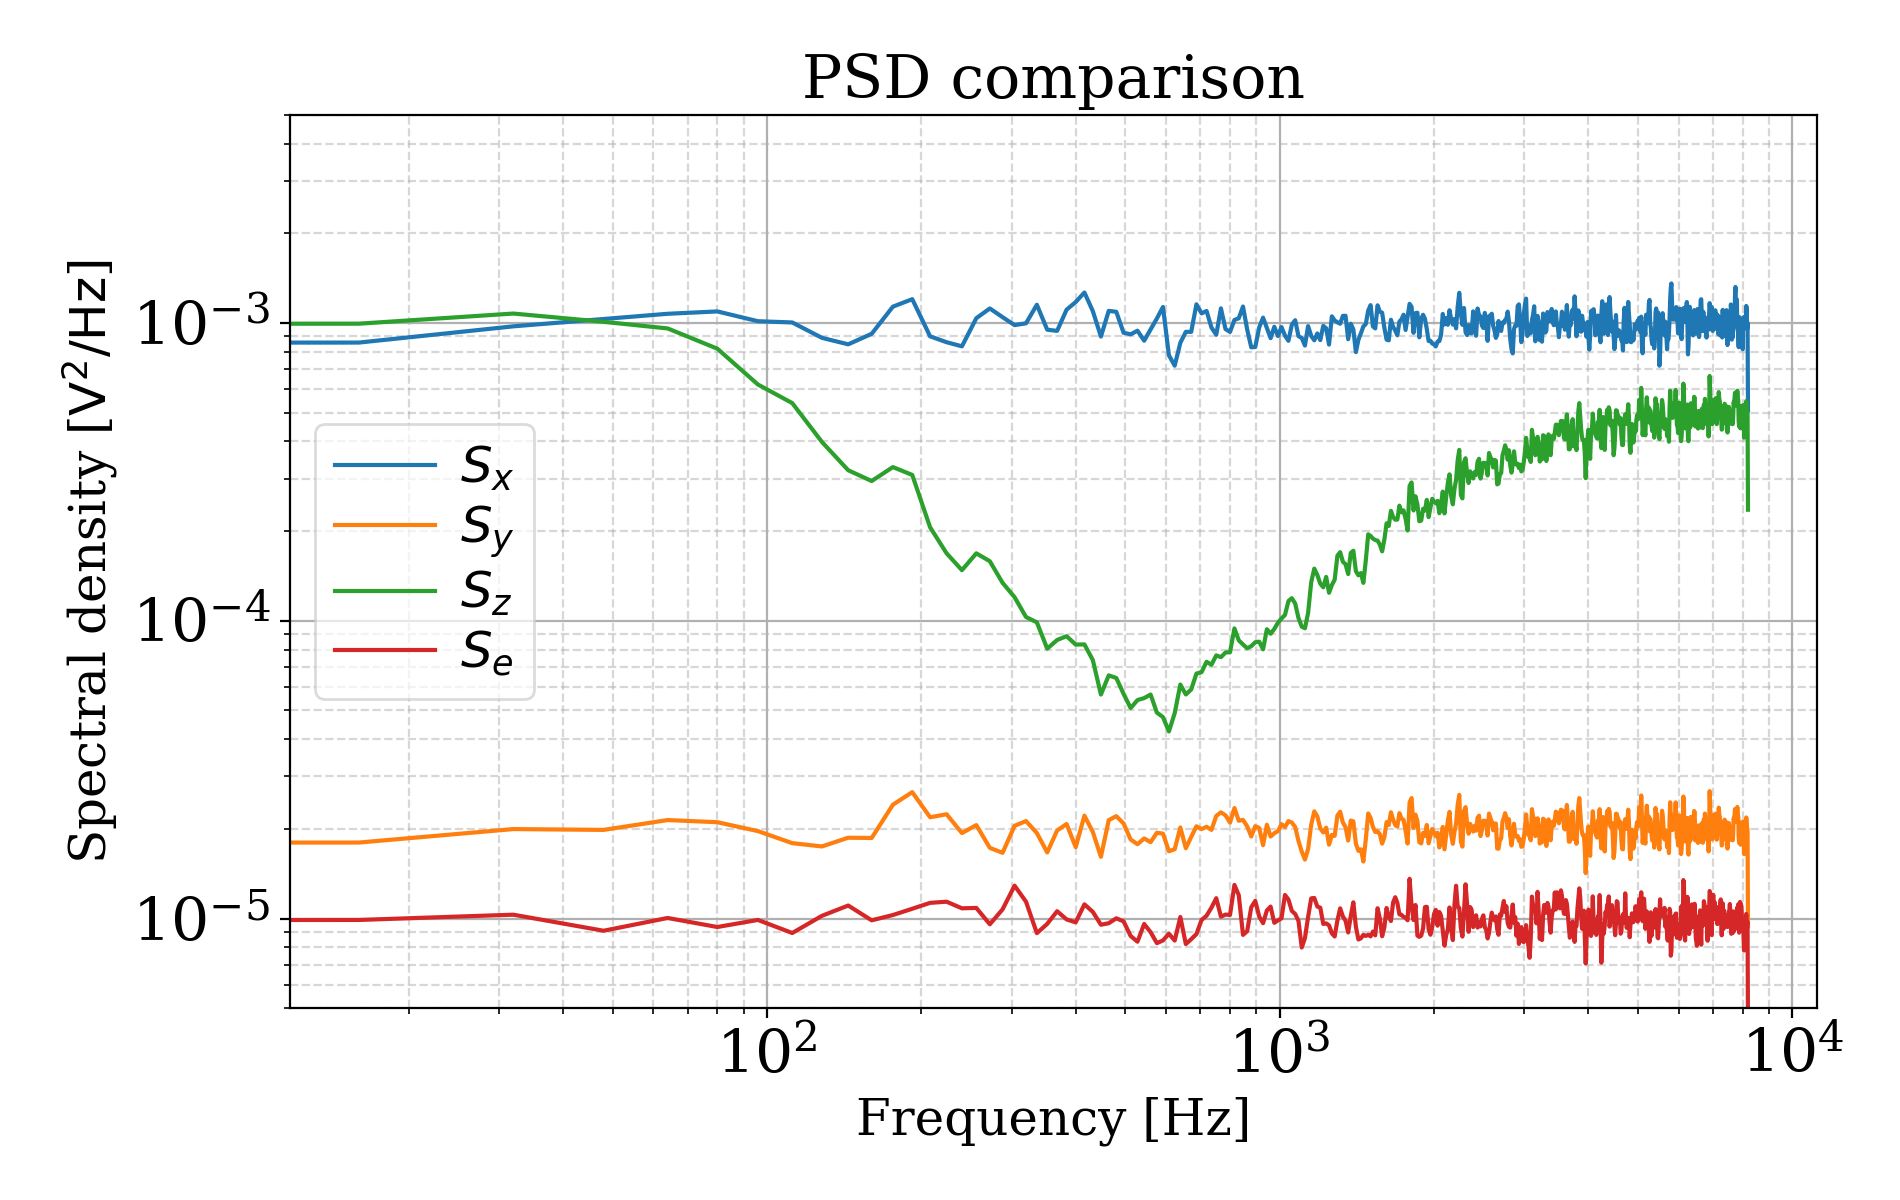

In [43]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, p3_Sxx, label="$S_{x}$")
s1.loglog(ff, p3_Syy, label="$S_{y}$")
s1.loglog(ff, p3_Szz, label="$S_{z}$")
s1.loglog(ff, p3_See, label="$S_{e}$")


s1.set_ylim([5e-6, 5e-3])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("PSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the conditioned spectrum $S_{y \cdot x}$
In this case, we can see that $S_{y \cdot x} = S_e$, which means our subtraction was successful.  
Even better, we were able to reconstruct $S_e$ without knowing it ahead of time, only knowledge of $x(t), y(t), z(t)$ is required.

<IPython.core.display.Javascript object>


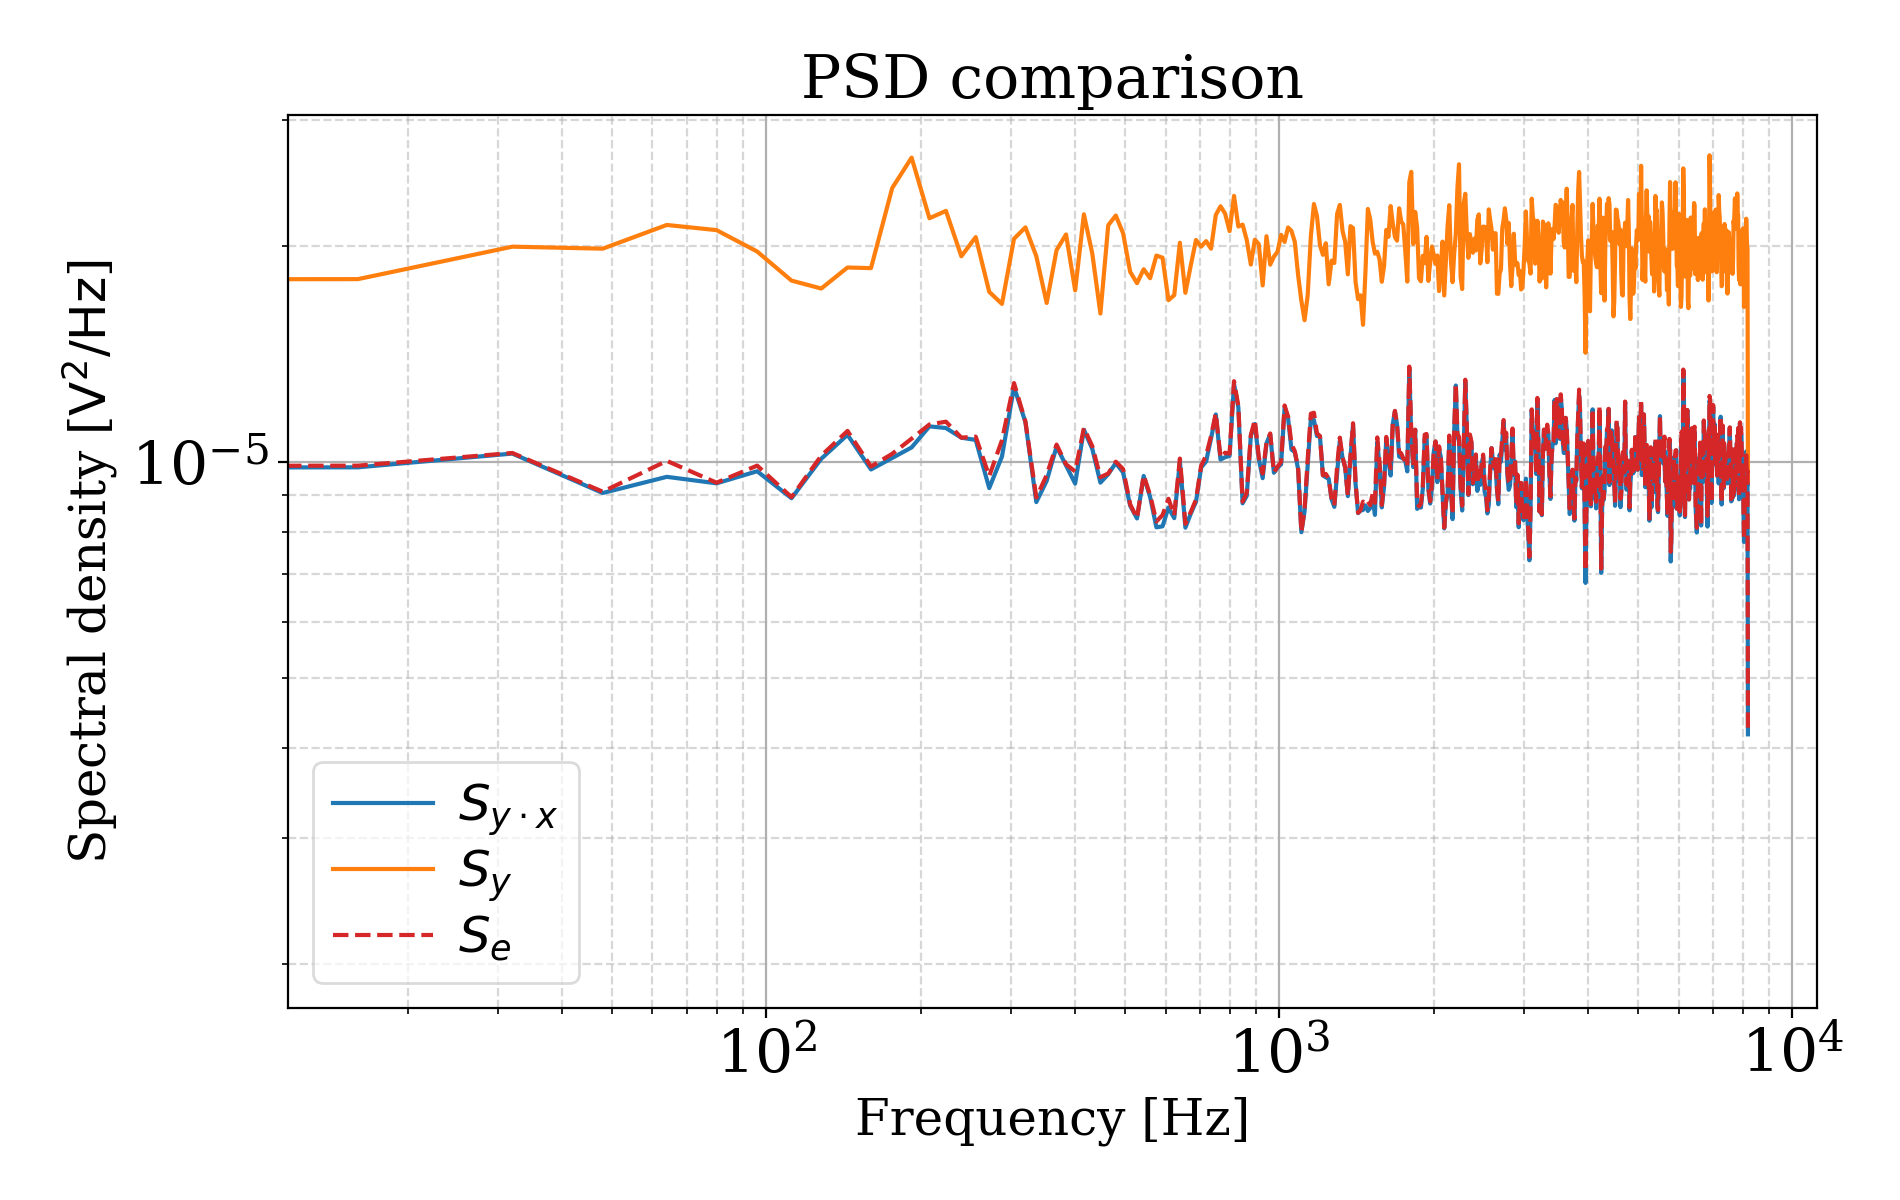

In [44]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))


s1.loglog(ff, p3_Syy_x, ls='-', label="$S_{y \cdot x}$")
s1.loglog(ff, p3_Syy, label="$S_{y}$")
# s1.loglog(ff, new_Syy_x_1, ls=':', label="$S_{y \cdot x}$")
s1.loglog(ff, p3_See, color="C3", ls='--', label="$S_{e}$")


# s1.set_ylim([5e-4, 5e-1])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("PSD comparison")
s1.set_ylabel("Spectral density [$\mathrm{V}^2/\mathrm{Hz}$]")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the conditioned spectra $S_{yz \cdot x}$
This part is interesting: we can do better resolving the conditioned cross spectral density in the region where $x(t)$ dominates $z(t)$.  

Because we know the influence of $x(t)$ on $z(t)$ really well, when it's removed we are left with good resolution of the noise underneath.

The direct measurement of $S_{ez}$ is more noisy, because it has no knowledge of $x(t)$ at all and must simply "average away" that uncorrelated noise.

<IPython.core.display.Javascript object>


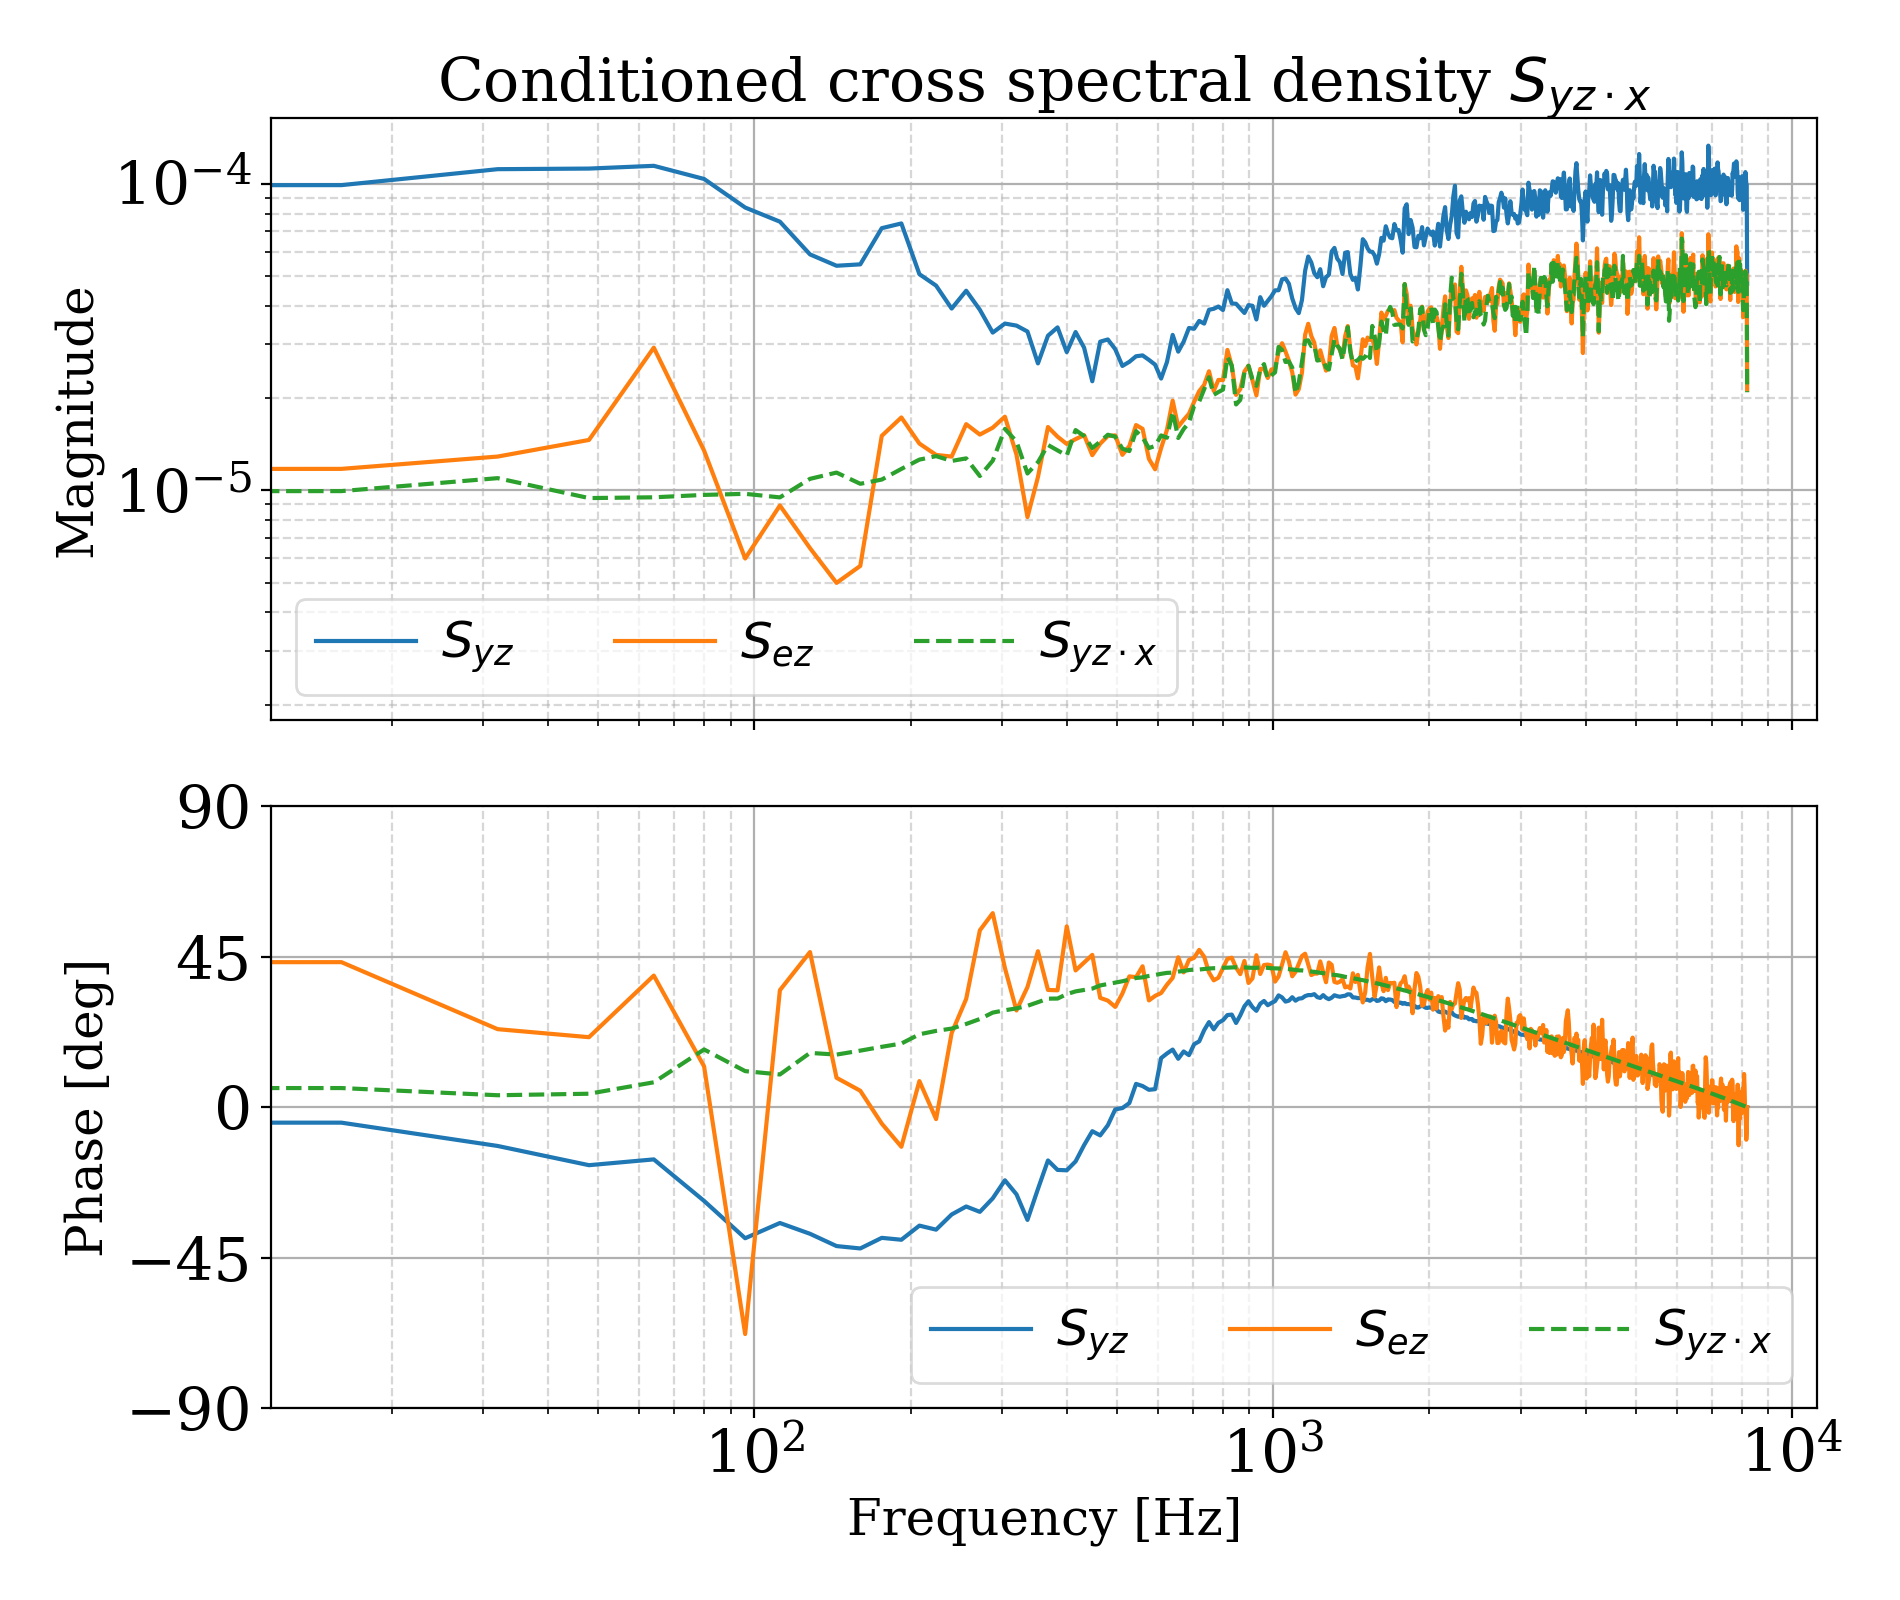

In [45]:
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(p3_Syz), label="$S_{yz}$")
s2.semilogx(ff, np.angle(p3_Syz, deg=True), label="$S_{yz}$")

s1.loglog(ff, np.abs(p3_Sez), label="$S_{ez}$")
s2.semilogx(ff, np.angle(p3_Sez, deg=True), label="$S_{ez}$")

s1.loglog(ff, np.abs(p3_Syz_x), ls='--', label="$S_{yz \cdot x}$")
s2.semilogx(ff, np.angle(p3_Syz_x, deg=True), ls='--', label="$S_{yz \cdot x}$")

# s1.set_ylim([5e-1, 1e1])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend(ncol=3)
s2.legend(ncol=3)

s1.set_title("Conditioned cross spectral density $S_{yz \cdot x}$")
s1.set_ylabel("Magnitude")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the (ordinary) coherence between signals
The coherence $\gamma^2$ between any two signals can be defined as
$$\gamma^2_{ab}(f) = \dfrac{|S_{ab}(f)|^2}{S_{aa}(f) S_{bb}(f)}$$
and is thought of as a representation of how correlated two signals are in a frequency regime.

Coherence is strongly related to the number of averages $N$.  
Two completely incoherent signals $a, b$ will return a coherence of about
$$\gamma^2_{ab} \approx \dfrac{1}{N}$$

<IPython.core.display.Javascript object>


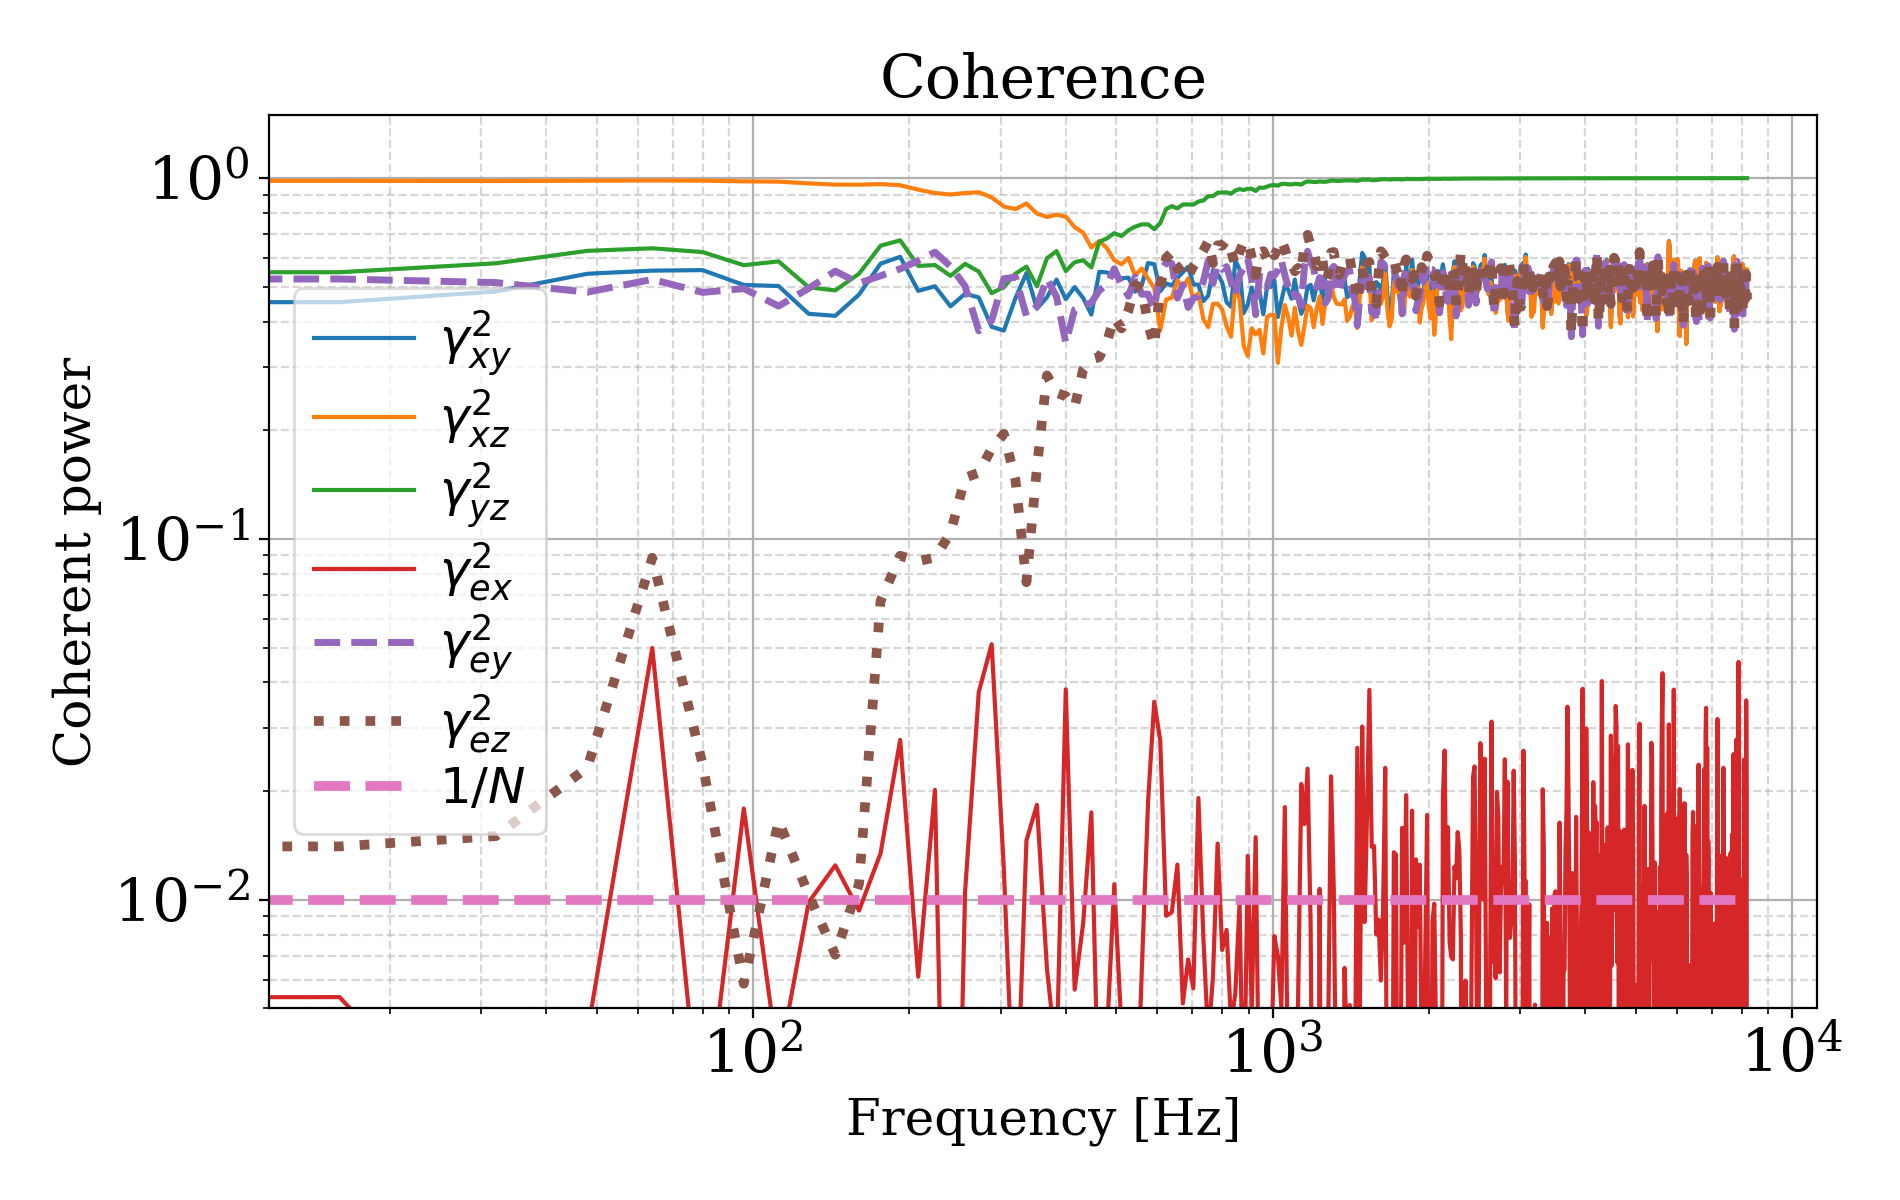

In [46]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, p3_Cxy, label="$\gamma^2_{xy}$")
s1.loglog(ff, p3_Cxz, label="$\gamma^2_{xz}$")
s1.loglog(ff, p3_Cyz, label="$\gamma^2_{yz}$")

s1.loglog(ff, p3_Cex, label="$\gamma^2_{ex}$")
s1.loglog(ff, p3_Cey, lw=2.5, ls="--", label="$\gamma^2_{ey}$")
s1.loglog(ff, p3_Cez, lw=3.5, ls=":", label="$\gamma^2_{ez}$")

s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

s1.set_ylim([5e-3, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Coherence")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

In the coherence plot above,
we can see the transition between when $x(t)$ contributions dominate $z(t)$ to when $y(t)$ contributions dominate $z(t)$, at around $500~\mathrm{Hz}$.

## Plot partial coherence $\gamma^2_{yz \cdot x}$
Like above, $\gamma^2_{yz \cdot x} \approx \gamma^2_{ez}$, because with the influence of $x(t)$ removed from $y(t)$, only $e(t)$ is left in $y(t)$.

Again, the estimate using $\gamma^2_{yz \cdot x}$ is better in the region where $x(t)$ previously dominated, since $x(t)$ can be removed with confidence.

$\gamma^2_{ez}$ has to contend with high $x(t)$ noise.

<IPython.core.display.Javascript object>


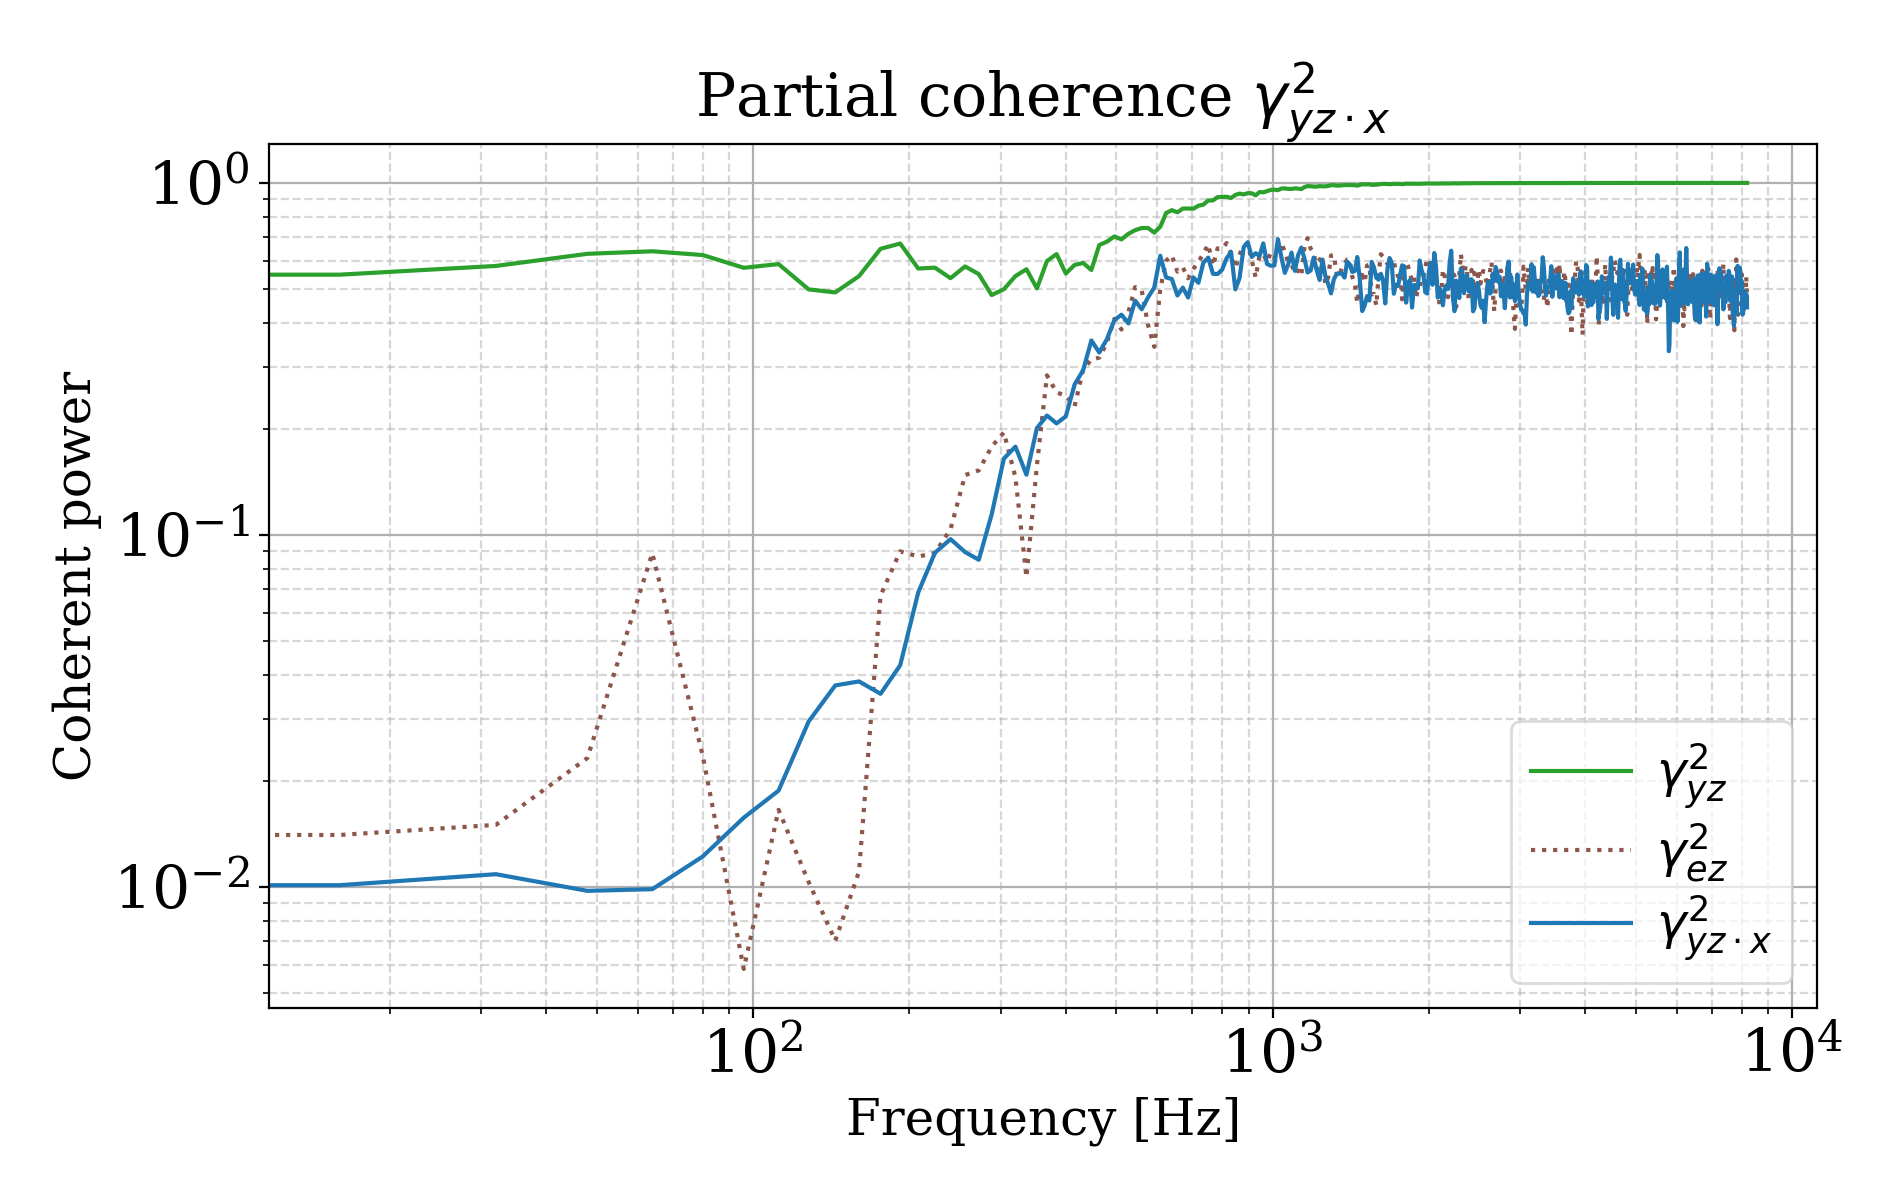

In [47]:
fig, (s1) = plt.subplots(1, figsize=(9.5,6))

s1.loglog(ff, p3_Cyz, color="C2", label="$\gamma^2_{yz}$")
s1.loglog(ff, p3_Cez, ls=":", color="C5", label="$\gamma^2_{ez}$")
s1.loglog(ff, p3_PCyz_x, label="$\gamma^2_{yz \cdot x}$")

# s1.loglog(ff, np.ones_like(ff)/averages, lw=3.5, ls="--", label="$1/N$")

# s1.set_ylim([1e-1, 1.5e0])

s1.grid(which="minor", ls="--", alpha=0.5)

s1.legend()

s1.set_title("Partial coherence $\gamma^2_{yz \cdot x}$")
s1.set_ylabel("Coherent power")
s1.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## Plot the transfer function $H_2$ and the estimates $\hat{H}_2$, $S_{yz}/S_y$ and $S_{ez}/S_{ey}$
The estimate $S_{ez}/S_{ey}$ has the advantage of being unbiased even if the excitation is not strong enough to resolve the transfer function everywhere.
We will explore this in Part 3.

<IPython.core.display.Javascript object>


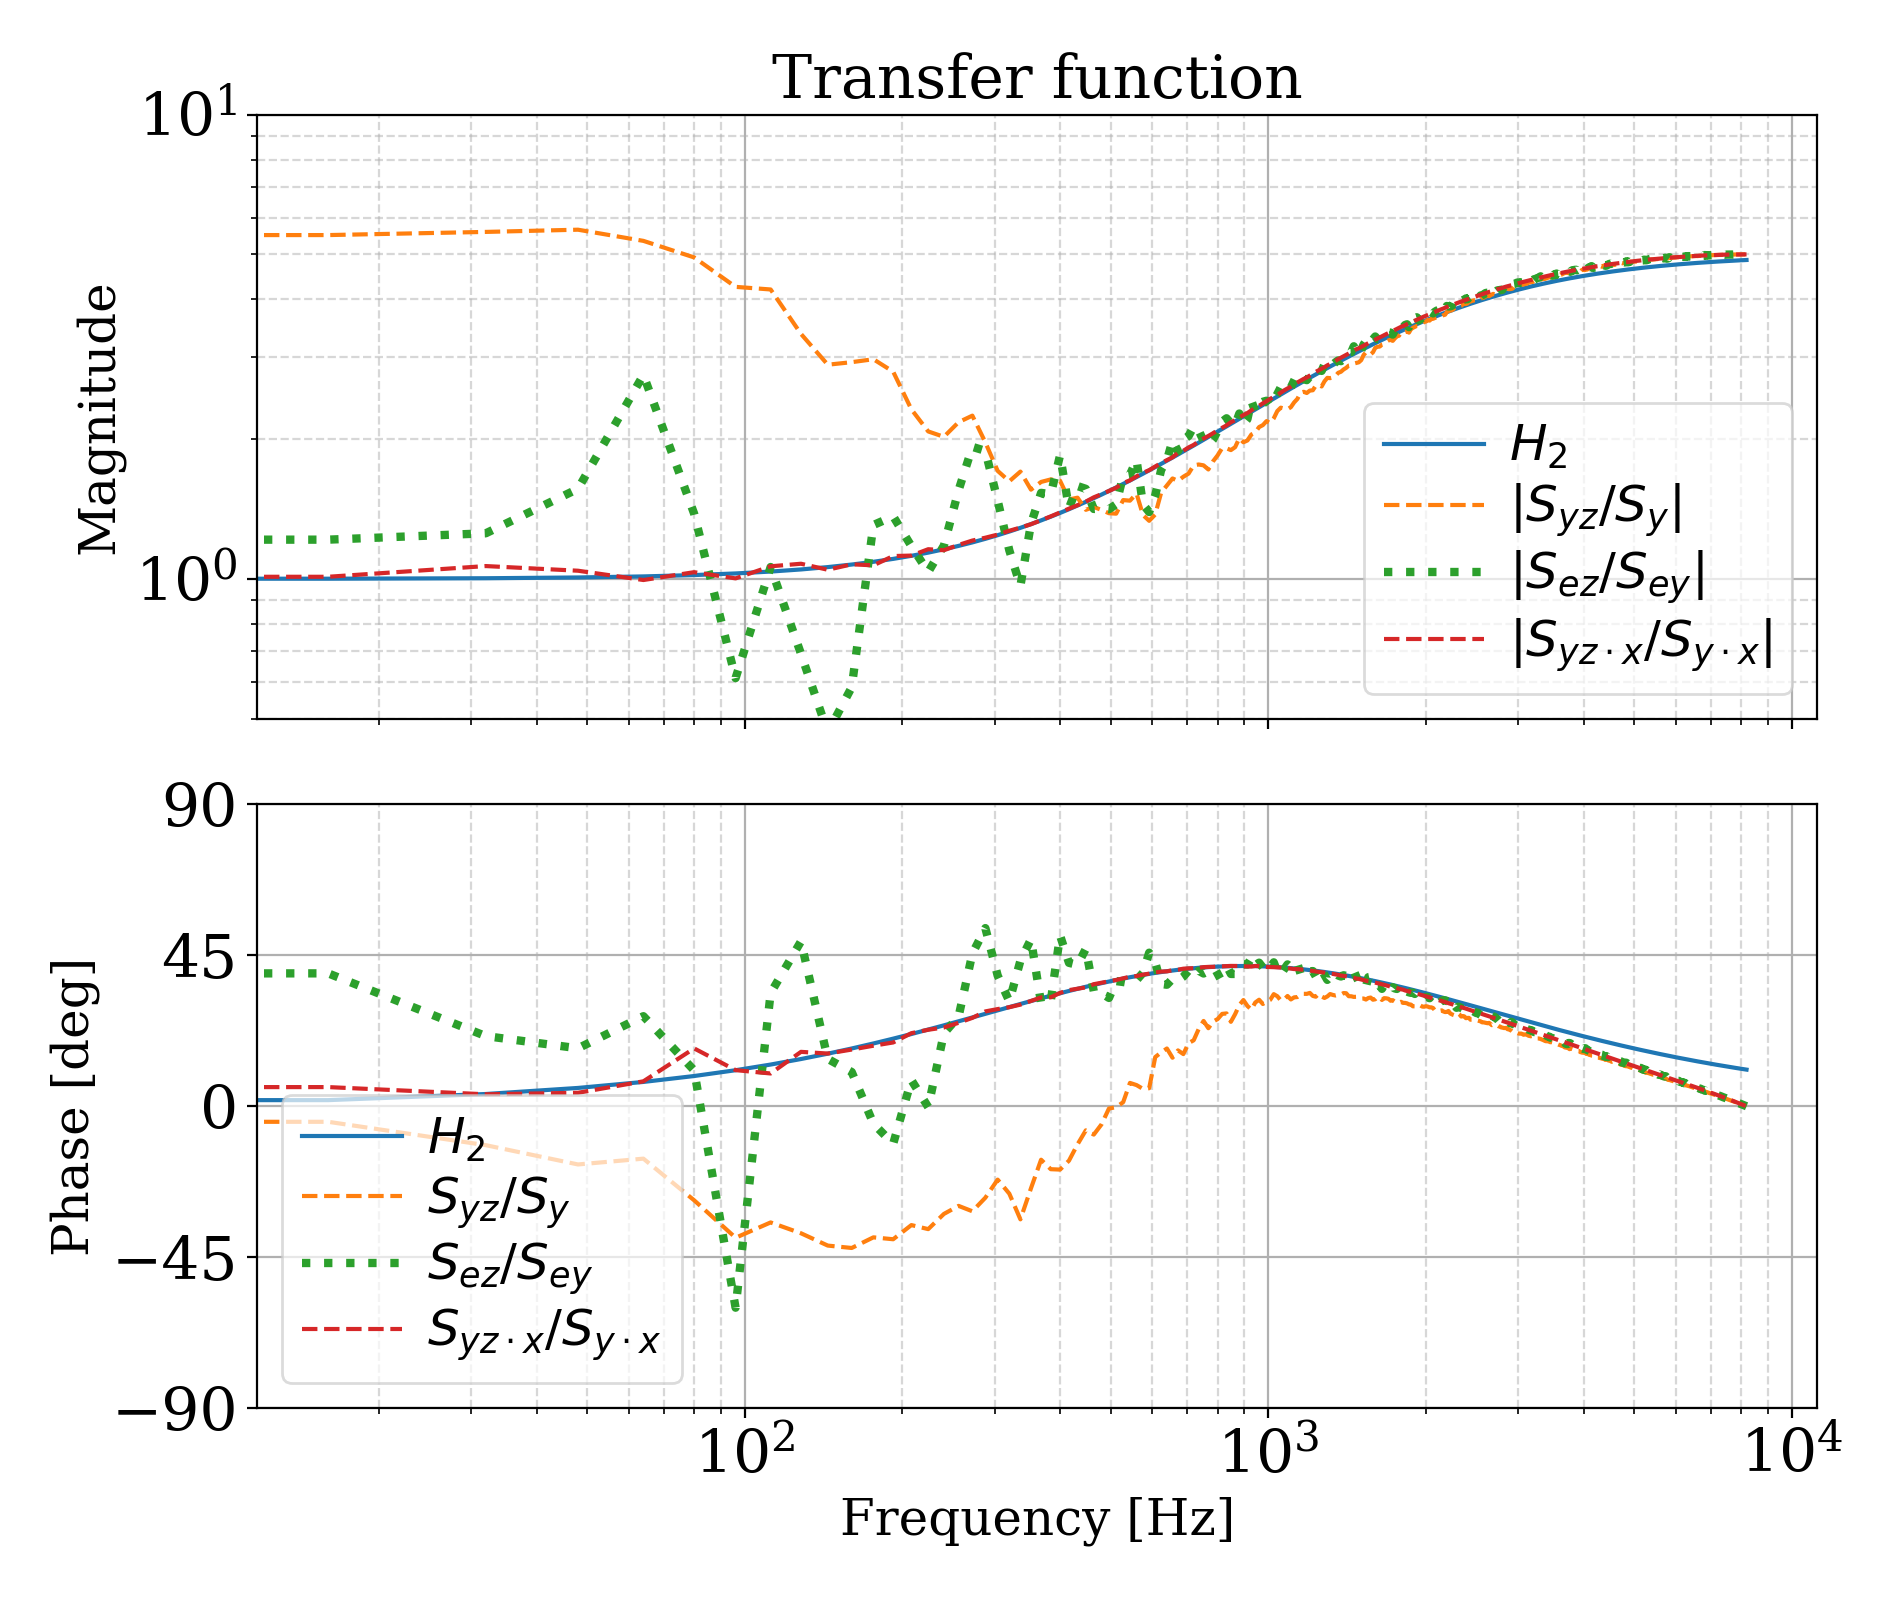

In [48]:
fig, (s1, s2) = plt.subplots(2, sharex=True, figsize=(9.5,8))

s1.loglog(ff, np.abs(h2), label="$H_2$")
s2.semilogx(ff, np.angle(h2, deg=True), label="$H_2$")

s1.loglog(ff, np.abs(p3_h2a), ls="--", label="$|S_{yz}/S_y|$")
s2.semilogx(ff, np.angle(p3_h2a, deg=True), ls="--", label="$S_{yz}/S_y$")

s1.loglog(ff, np.abs(p3_h2e), ls=":", lw=3, label="$|S_{ez}/S_{ey}|$")
s2.semilogx(ff, np.angle(p3_h2e, deg=True), ls=":", lw=3, label="$S_{ez}/S_{ey}$")

s1.loglog(ff, np.abs(p3_h2c), ls="--", label="$|S_{yz \cdot x}/S_{y \cdot x}|$")
s2.semilogx(ff, np.angle(p3_h2c, deg=True), ls="--", label="$S_{yz \cdot x}/S_{y \cdot x}$")

s1.set_ylim([5e-1, 1e1])
s2.set_ylim([-90, 90])
s2.set_yticks(np.arange(-2, 3) * 45)

s1.grid(which="minor", ls="--", alpha=0.5)
s2.grid(which="minor", ls="--", alpha=0.5)

s1.legend()
s2.legend()

s1.set_title("Transfer function")
s1.set_ylabel("Magnitude")
s2.set_ylabel("Phase [deg]")
s2.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

In the $H_2$ transfer function estimates above,
we see the estimates are great in the frequency region above $500~\mathrm{Hz}$ when the coherence is high.

However, the estimates fall apart in the low frequency region, although the unbiased estimator $S_{ez}/S_{ey}$ does better.  

This is because $S_{yz}/S_{y}$ is susceptible to bias from extraneous noise, which in this example is the input from $x(t)$.

Even better is the conditioned estimator $S_{yz \cdot x}/S_{y \cdot x}$, which removes the measured influence of $x(t)$ from $y(t)$'s spectra $S_{yz}$ and $S_{y}$.  Because we know the noise source $x(t)$, we can remove it and get a very good estimate of $H_2$.